# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

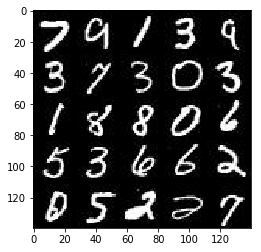

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

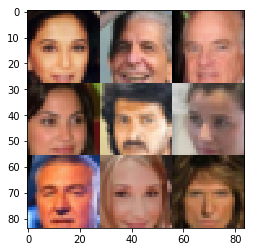

In [3]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels), name = "real_input")
    z_input = tf.placeholder(tf.float32, (None,z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [43]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse = reuse):
        alpha = 0.02
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding = "same")
       # x = tf.contrib.layers.conv2d(images, 64, 5, stride=2, padding="same", 
        #                                activation_fn=None,
        #                                weights_initializer=tf.truncated_normal_initializer(stddev = 0.02))
        x = tf.maximum(alpha*x, x)

        x = tf.layers.conv2d(images, 128, 5, strides=2, padding = "same")
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha*x, x)
       
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding = "same")
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d(x, 256, 5, strides=1, padding = "same")
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha*x, x)
        
        x = tf.reshape(x, (-1, 4*4*256))
    
        logits = tf.layers.dense(x, 1, activation = None)
        out = tf.sigmoid(logits)
    
        return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [44]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.02
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7 ,512))
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(alpha*x, x)

        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding = "same")
        #x = tf.contrib.layers.conv2d_transpose(x, 128, 5, stride=2, padding="same", 
        #                                       activation_fn=None,
        #                                       weights_initializer=tf.truncated_normal_initializer(stddev = 0.02))                                    
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(alpha*x, x)

        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding = "same")
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(alpha*x, x)

        x = tf.layers.conv2d_transpose(x, 64, 5, strides=1, padding = "same")
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(alpha*x, x)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding="same")
        output = tf.tanh(logits)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [45]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_real_logits, d_real_out = discriminator(input_real)
    d_fake_logits, d_fake_out = discriminator(g_model, reuse = True)
    smooth = 0.99
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, 
                                                                    labels=tf.ones_like(d_fake_logits) * smooth))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_real_logits, 
                                                                         labels = tf.ones_like(d_real_logits)* smooth))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, 
                                                                         labels = tf.zeros_like(d_fake_logits)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [46]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    
    gen_var = [variable for variable in variables if variable.name.startswith("generator")]
    dis_var = [variable for variable in variables if variable.name.startswith("discriminator")]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = dis_var)
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = gen_var)
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    #return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [48]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z_input, learn_rate = model_inputs(data_shape[1],data_shape[2], data_shape[3],z_dim)
    #loss = []
    #images = []
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    
    d_optimizer , g_optimizer = model_opt(d_loss, g_loss, learning_rate, beta1)
    #saver = tf.train.Saver()
    steps = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                
                steps +=1
                batch_z = np.random.uniform(-1,1, size = [batch_size, z_dim])
                
                _ = sess.run(d_optimizer, feed_dict={real_input: batch_images, z_input: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_optimizer, feed_dict={real_input: batch_images, z_input: batch_z, learn_rate:learning_rate})
          #      _ = sess.run(g_optimizer, feed_dict={real_input: batch_images, z_input: batch_z})
                
                if steps %2 == 0:
                    train_d_loss = sess.run(d_loss, {real_input: batch_images, z_input: batch_z})
                    train_g_loss = g_loss.eval({z_input: batch_z})
                    print("Kierros {}, generator {} discriminator {}".format(steps, train_g_loss, train_d_loss))
                    #loss.append("Kierros {}, generator {} discriminator {}".format(steps, train_g_loss, train_d_loss)
                if steps %50 == 0:
                    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                    show_generator_output(sess, 4, z_input, data_shape[3], data_image_mode)
                    #images.append(show_generator_output(sess, 4, z_input, data_shape[3], data_image_mode))
                
            print("Epoch {}!".format(epoch_i))
            sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            show_generator_output(sess, 16, z_input, data_shape[3], data_image_mode)
        #saver.save(sess, './checkpoints/gen.ckpt')        
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Kierros 2, generator 0.09303964674472809 discriminator 3.8449795246124268
Kierros 4, generator 0.374243825674057 discriminator 2.0576677322387695
Kierros 6, generator 0.4203883707523346 discriminator 1.5331437587738037
Kierros 8, generator 0.4128433167934418 discriminator 1.6417326927185059
Kierros 10, generator 0.3898385167121887 discriminator 1.8153834342956543
Kierros 12, generator 0.380953311920166 discriminator 1.7609100341796875
Kierros 14, generator 0.7246866226196289 discriminator 1.3785216808319092
Kierros 16, generator 0.7497396469116211 discriminator 1.0783562660217285
Kierros 18, generator 0.841417133808136 discriminator 1.0042786598205566
Kierros 20, generator 0.6920440793037415 discriminator 1.189191460609436
Kierros 22, generator 0.6480908989906311 discriminator 1.3180814981460571
Kierros 24, generator 0.7379470467567444 discriminator 0.9965474605560303
Kierros 26, generator 0.8385658860206604 discriminator 0.9647103548049927
Kierros 28, generator 0.7230974435806274 disc

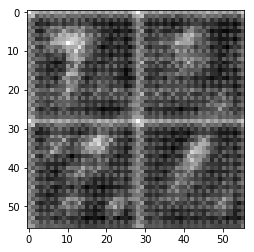

Kierros 52, generator 0.8011466264724731 discriminator 1.12567937374115
Kierros 54, generator 0.8024286031723022 discriminator 1.1747817993164062
Kierros 56, generator 0.7385314702987671 discriminator 1.1405129432678223
Kierros 58, generator 0.6011377573013306 discriminator 1.2060316801071167
Kierros 60, generator 0.7303512096405029 discriminator 1.170450210571289
Kierros 62, generator 0.9358791708946228 discriminator 1.0937936305999756
Kierros 64, generator 1.063741683959961 discriminator 1.1410975456237793
Kierros 66, generator 1.0856103897094727 discriminator 1.187425971031189
Kierros 68, generator 0.8999539017677307 discriminator 1.3080273866653442
Kierros 70, generator 0.8959845900535583 discriminator 1.1581315994262695
Kierros 72, generator 0.8148126602172852 discriminator 1.105589509010315
Kierros 74, generator 0.9101096391677856 discriminator 1.103839635848999
Kierros 76, generator 0.8322892189025879 discriminator 1.0986748933792114
Kierros 78, generator 0.7995233535766602 disc

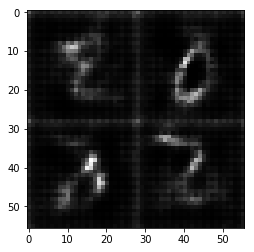

Kierros 102, generator 0.6560401916503906 discriminator 1.2222181558609009
Kierros 104, generator 0.5338737964630127 discriminator 1.3606083393096924
Kierros 106, generator 0.6368269324302673 discriminator 1.2806288003921509
Kierros 108, generator 0.6964988112449646 discriminator 1.2504476308822632
Kierros 110, generator 0.6333078145980835 discriminator 1.241260051727295
Kierros 112, generator 0.6827651858329773 discriminator 1.2263929843902588
Kierros 114, generator 0.7571456432342529 discriminator 1.245317816734314
Kierros 116, generator 0.8726351261138916 discriminator 1.1914598941802979
Kierros 118, generator 0.8233541250228882 discriminator 1.215897798538208
Kierros 120, generator 0.7352136969566345 discriminator 1.2211933135986328
Kierros 122, generator 0.7387871742248535 discriminator 1.291684627532959
Kierros 124, generator 0.8068850636482239 discriminator 1.3047128915786743
Kierros 126, generator 0.958937406539917 discriminator 1.2679228782653809
Kierros 128, generator 1.15300

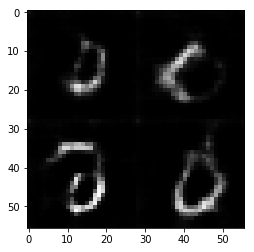

Kierros 152, generator 0.5805590152740479 discriminator 1.2518432140350342
Kierros 154, generator 0.7255983948707581 discriminator 1.1670117378234863
Kierros 156, generator 0.7370438575744629 discriminator 1.209595799446106
Kierros 158, generator 1.0110316276550293 discriminator 1.1907262802124023
Kierros 160, generator 1.19770085811615 discriminator 1.2703627347946167
Kierros 162, generator 0.9879117012023926 discriminator 1.2043765783309937
Kierros 164, generator 0.8712961077690125 discriminator 1.1966724395751953
Kierros 166, generator 0.7714405655860901 discriminator 1.3333635330200195
Kierros 168, generator 0.7688435316085815 discriminator 1.23634672164917
Kierros 170, generator 0.8363260626792908 discriminator 1.1533503532409668
Kierros 172, generator 0.9330704212188721 discriminator 1.1827914714813232
Kierros 174, generator 1.0420645475387573 discriminator 1.125894546508789
Kierros 176, generator 1.1961379051208496 discriminator 1.273808240890503
Kierros 178, generator 0.9791833

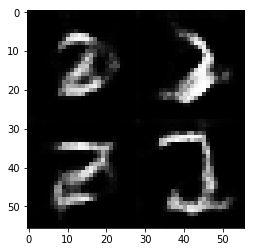

Kierros 202, generator 0.9654673337936401 discriminator 1.2062149047851562
Kierros 204, generator 0.7424878478050232 discriminator 1.205052137374878
Kierros 206, generator 0.5579675436019897 discriminator 1.2865079641342163
Kierros 208, generator 0.5846928954124451 discriminator 1.2271596193313599
Kierros 210, generator 0.5595730543136597 discriminator 1.2722465991973877
Kierros 212, generator 0.6700248718261719 discriminator 1.2389729022979736
Kierros 214, generator 0.8294942378997803 discriminator 1.1187596321105957
Kierros 216, generator 1.0034595727920532 discriminator 1.2852952480316162
Kierros 218, generator 0.9436846375465393 discriminator 1.3170948028564453
Kierros 220, generator 0.817560076713562 discriminator 1.23698890209198
Kierros 222, generator 0.7731077075004578 discriminator 1.2343401908874512
Kierros 224, generator 0.7256497740745544 discriminator 1.1552822589874268
Kierros 226, generator 0.49616825580596924 discriminator 1.330938696861267
Kierros 228, generator 0.4699

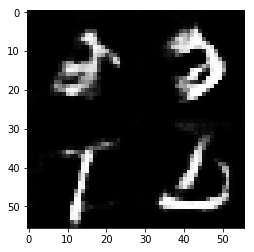

Kierros 252, generator 0.8426283001899719 discriminator 1.1815606355667114
Kierros 254, generator 0.8505476117134094 discriminator 1.2848076820373535
Kierros 256, generator 0.9856508374214172 discriminator 1.358142614364624
Kierros 258, generator 0.9656303524971008 discriminator 1.2543578147888184
Kierros 260, generator 1.1245659589767456 discriminator 1.2744840383529663
Kierros 262, generator 1.1650516986846924 discriminator 1.2456843852996826
Kierros 264, generator 0.9352906942367554 discriminator 1.1969269514083862
Kierros 266, generator 1.0443942546844482 discriminator 1.313969612121582
Kierros 268, generator 1.0316590070724487 discriminator 1.3127961158752441
Kierros 270, generator 1.0054796934127808 discriminator 1.2545782327651978
Kierros 272, generator 0.8227511048316956 discriminator 1.2213990688323975
Kierros 274, generator 0.9835202693939209 discriminator 1.230290174484253
Kierros 276, generator 1.1617202758789062 discriminator 1.2179968357086182
Kierros 278, generator 0.925

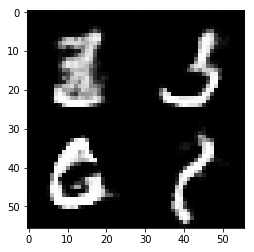

Kierros 302, generator 0.8705751895904541 discriminator 1.3540704250335693
Kierros 304, generator 0.7827459573745728 discriminator 1.2756166458129883
Kierros 306, generator 0.8558548092842102 discriminator 1.2672574520111084
Kierros 308, generator 1.0828477144241333 discriminator 1.2873928546905518
Kierros 310, generator 1.1347306966781616 discriminator 1.2866065502166748
Kierros 312, generator 1.0487924814224243 discriminator 1.2769770622253418
Kierros 314, generator 0.8665998578071594 discriminator 1.303003191947937
Kierros 316, generator 0.9743225574493408 discriminator 1.2254029512405396
Kierros 318, generator 1.039524793624878 discriminator 1.309851884841919
Kierros 320, generator 0.9941230416297913 discriminator 1.2677747011184692
Kierros 322, generator 0.9933507442474365 discriminator 1.2435765266418457
Kierros 324, generator 0.787108838558197 discriminator 1.2698743343353271
Kierros 326, generator 0.8294210433959961 discriminator 1.4503724575042725
Kierros 328, generator 0.5966

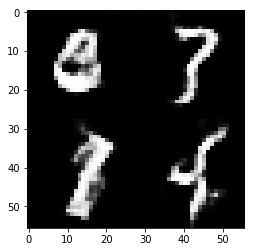

Kierros 352, generator 0.7567863464355469 discriminator 1.1773681640625
Kierros 354, generator 0.8870002031326294 discriminator 1.2057136297225952
Kierros 356, generator 0.7866910099983215 discriminator 1.2481309175491333
Kierros 358, generator 0.6734135150909424 discriminator 1.3043713569641113
Kierros 360, generator 0.614255428314209 discriminator 1.2566945552825928
Kierros 362, generator 0.7358254194259644 discriminator 1.2065129280090332
Kierros 364, generator 0.9114847779273987 discriminator 1.2474192380905151
Kierros 366, generator 1.2352436780929565 discriminator 1.3591333627700806
Kierros 368, generator 1.1992523670196533 discriminator 1.307510495185852
Kierros 370, generator 0.921386182308197 discriminator 1.2448217868804932
Kierros 372, generator 0.8056297898292542 discriminator 1.3403669595718384
Kierros 374, generator 0.9486790299415588 discriminator 1.2914009094238281
Kierros 376, generator 0.8749432563781738 discriminator 1.2755157947540283
Kierros 378, generator 0.926850

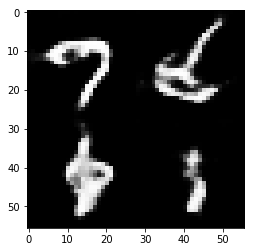

Kierros 402, generator 0.9374961853027344 discriminator 1.253025770187378
Kierros 404, generator 0.8500314950942993 discriminator 1.259901523590088
Kierros 406, generator 0.668714702129364 discriminator 1.3076319694519043
Kierros 408, generator 0.5627281665802002 discriminator 1.334368348121643
Kierros 410, generator 0.48097309470176697 discriminator 1.3876172304153442
Kierros 412, generator 0.4734848439693451 discriminator 1.3462920188903809
Kierros 414, generator 0.5221151113510132 discriminator 1.2765332460403442
Kierros 416, generator 0.5777930021286011 discriminator 1.3261152505874634
Kierros 418, generator 0.7462072372436523 discriminator 1.2561770677566528
Kierros 420, generator 0.8696957230567932 discriminator 1.2072172164916992
Kierros 422, generator 1.0295192003250122 discriminator 1.2201714515686035
Kierros 424, generator 0.9010148048400879 discriminator 1.2550108432769775
Kierros 426, generator 0.8244980573654175 discriminator 1.1557410955429077
Kierros 428, generator 0.805

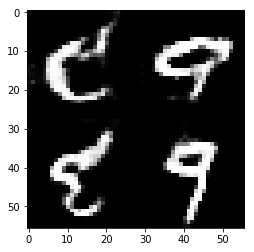

Kierros 452, generator 0.5093715190887451 discriminator 1.287904143333435
Kierros 454, generator 0.5719178915023804 discriminator 1.2754863500595093
Kierros 456, generator 0.5426117181777954 discriminator 1.288318157196045
Kierros 458, generator 0.6686137318611145 discriminator 1.1777493953704834
Kierros 460, generator 0.7654266357421875 discriminator 1.1442465782165527
Kierros 462, generator 0.6180182099342346 discriminator 1.2454893589019775
Kierros 464, generator 0.6230844855308533 discriminator 1.2161225080490112
Kierros 466, generator 0.4914484918117523 discriminator 1.3628722429275513
Kierros 468, generator 0.6414307951927185 discriminator 1.201776146888733
Kierros 470, generator 0.8734609484672546 discriminator 1.2022979259490967
Kierros 472, generator 0.8714402914047241 discriminator 1.3363533020019531
Kierros 474, generator 0.6836181282997131 discriminator 1.1849162578582764
Kierros 476, generator 0.6755202412605286 discriminator 1.1785833835601807
Kierros 478, generator 0.641

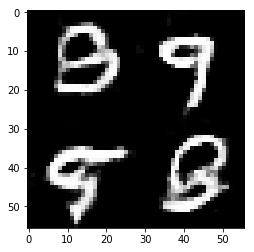

Kierros 502, generator 0.9294703602790833 discriminator 1.1686031818389893
Kierros 504, generator 1.195597529411316 discriminator 1.2766766548156738
Kierros 506, generator 0.9107524156570435 discriminator 1.2178844213485718
Kierros 508, generator 0.7698264718055725 discriminator 1.285333514213562
Kierros 510, generator 0.8846120834350586 discriminator 1.1502246856689453
Kierros 512, generator 1.027931809425354 discriminator 1.1649377346038818
Kierros 514, generator 1.1310259103775024 discriminator 1.134097695350647
Kierros 516, generator 1.0618069171905518 discriminator 1.2269132137298584
Kierros 518, generator 1.1548882722854614 discriminator 1.2027487754821777
Kierros 520, generator 1.4480774402618408 discriminator 1.2508820295333862
Kierros 522, generator 1.151566743850708 discriminator 1.1415725946426392
Kierros 524, generator 0.8391860127449036 discriminator 1.0987213850021362
Kierros 526, generator 0.7177711725234985 discriminator 1.161301612854004
Kierros 528, generator 0.694675

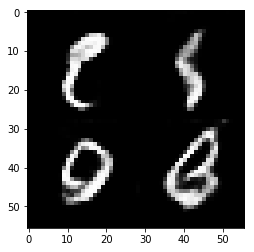

Kierros 552, generator 1.7970322370529175 discriminator 1.8416669368743896
Kierros 554, generator 1.3155394792556763 discriminator 1.2534178495407104
Kierros 556, generator 0.8323874473571777 discriminator 1.175961971282959
Kierros 558, generator 0.747252345085144 discriminator 1.1173104047775269
Kierros 560, generator 0.8647984862327576 discriminator 1.1488584280014038
Kierros 562, generator 0.9098571538925171 discriminator 1.4000139236450195
Kierros 564, generator 0.8077120780944824 discriminator 1.1224637031555176
Kierros 566, generator 0.8965449333190918 discriminator 1.0784506797790527
Kierros 568, generator 0.7869600057601929 discriminator 1.1087239980697632
Kierros 570, generator 0.640269935131073 discriminator 1.1482900381088257
Kierros 572, generator 0.5196912884712219 discriminator 1.2566927671432495
Kierros 574, generator 0.6121004223823547 discriminator 1.1564323902130127
Kierros 576, generator 0.6602422595024109 discriminator 1.177428960800171
Kierros 578, generator 0.8115

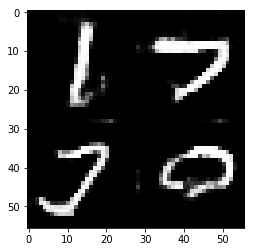

Kierros 602, generator 0.8826749920845032 discriminator 1.0513801574707031
Kierros 604, generator 1.029192566871643 discriminator 1.0676988363265991
Kierros 606, generator 1.290023684501648 discriminator 1.1777238845825195
Kierros 608, generator 1.261025309562683 discriminator 1.2314670085906982
Kierros 610, generator 1.1390937566757202 discriminator 1.2962603569030762
Kierros 612, generator 1.0344223976135254 discriminator 1.2127904891967773
Kierros 614, generator 1.3392518758773804 discriminator 1.2715153694152832
Kierros 616, generator 1.2844117879867554 discriminator 1.1580697298049927
Kierros 618, generator 1.1307514905929565 discriminator 1.1378743648529053
Kierros 620, generator 1.2078806161880493 discriminator 1.072717547416687
Kierros 622, generator 1.2467728853225708 discriminator 1.0409142971038818
Kierros 624, generator 1.13042414188385 discriminator 1.1785321235656738
Kierros 626, generator 1.5171183347702026 discriminator 1.3202054500579834
Kierros 628, generator 1.448074

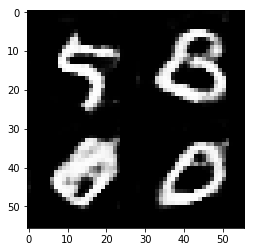

Kierros 652, generator 0.8339989185333252 discriminator 1.040391206741333
Kierros 654, generator 1.0962947607040405 discriminator 1.1279178857803345
Kierros 656, generator 1.3827635049819946 discriminator 1.2464520931243896
Kierros 658, generator 1.3702601194381714 discriminator 1.4415627717971802
Kierros 660, generator 1.295833945274353 discriminator 1.0934038162231445
Kierros 662, generator 1.130459189414978 discriminator 1.1133297681808472
Kierros 664, generator 0.996368944644928 discriminator 1.0611729621887207
Kierros 666, generator 0.8248538374900818 discriminator 1.1548731327056885
Kierros 668, generator 0.8884260058403015 discriminator 1.1003066301345825
Kierros 670, generator 0.7536461353302002 discriminator 1.0736515522003174
Kierros 672, generator 0.7232109308242798 discriminator 1.0660629272460938
Kierros 674, generator 0.6816115975379944 discriminator 1.099487543106079
Kierros 676, generator 0.6765176653862 discriminator 1.1620182991027832
Kierros 678, generator 0.76577013

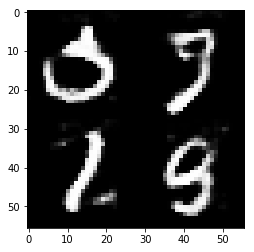

Kierros 702, generator 0.6506838202476501 discriminator 1.1816809177398682
Kierros 704, generator 0.6755847334861755 discriminator 1.142752766609192
Kierros 706, generator 0.47346991300582886 discriminator 1.656275987625122
Kierros 708, generator 0.7297549843788147 discriminator 1.08162260055542
Kierros 710, generator 0.786954402923584 discriminator 1.0717817544937134
Kierros 712, generator 0.7329055070877075 discriminator 1.108884572982788
Kierros 714, generator 0.7304402589797974 discriminator 1.0730071067810059
Kierros 716, generator 0.8752007484436035 discriminator 1.018195629119873
Kierros 718, generator 0.5826584696769714 discriminator 1.17826509475708
Kierros 720, generator 0.5921364426612854 discriminator 1.13882577419281
Kierros 722, generator 0.6067023873329163 discriminator 1.1421467065811157
Kierros 724, generator 0.6725931167602539 discriminator 1.1043596267700195
Kierros 726, generator 0.8797250986099243 discriminator 0.9942773580551147
Kierros 728, generator 0.9505844116

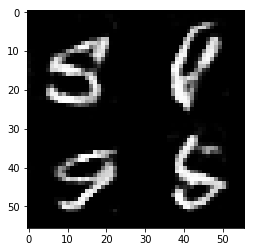

Kierros 752, generator 1.175618052482605 discriminator 1.0468862056732178
Kierros 754, generator 1.1233952045440674 discriminator 1.0201809406280518
Kierros 756, generator 1.2286336421966553 discriminator 1.1932625770568848
Kierros 758, generator 1.447770595550537 discriminator 1.2364392280578613
Kierros 760, generator 1.6169114112854004 discriminator 1.5369980335235596
Kierros 762, generator 1.2375952005386353 discriminator 1.2727012634277344
Kierros 764, generator 1.0972026586532593 discriminator 1.0587862730026245
Kierros 766, generator 1.208823800086975 discriminator 1.053765058517456
Kierros 768, generator 1.3496520519256592 discriminator 1.0825741291046143
Kierros 770, generator 1.2503859996795654 discriminator 1.051654577255249
Kierros 772, generator 1.0869832038879395 discriminator 0.9423702359199524
Kierros 774, generator 0.9817345142364502 discriminator 1.0963475704193115
Kierros 776, generator 0.8931775093078613 discriminator 1.0395344495773315
Kierros 778, generator 0.73659

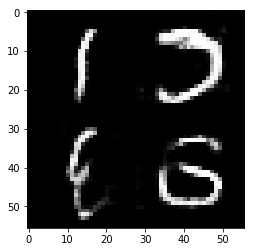

Kierros 802, generator 0.6737775206565857 discriminator 1.1453526020050049
Kierros 804, generator 0.9373502135276794 discriminator 0.9900150299072266
Kierros 806, generator 1.0365697145462036 discriminator 1.041646957397461
Kierros 808, generator 1.190383791923523 discriminator 1.0296189785003662
Kierros 810, generator 1.1461403369903564 discriminator 1.0685679912567139
Kierros 812, generator 1.0083338022232056 discriminator 1.051103115081787
Kierros 814, generator 0.9948522448539734 discriminator 1.0057346820831299
Kierros 816, generator 0.9823670387268066 discriminator 0.9584015607833862
Kierros 818, generator 1.160860538482666 discriminator 1.064966082572937
Kierros 820, generator 1.160120964050293 discriminator 1.053501009941101
Kierros 822, generator 0.95989990234375 discriminator 1.1141668558120728
Kierros 824, generator 1.1113096475601196 discriminator 1.0969139337539673
Kierros 826, generator 1.1417397260665894 discriminator 1.0017833709716797
Kierros 828, generator 0.965296924

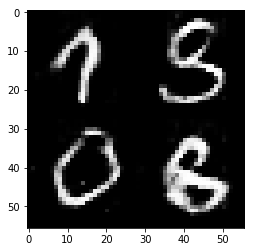

Kierros 852, generator 1.1361855268478394 discriminator 0.9747968316078186
Kierros 854, generator 1.3085932731628418 discriminator 1.0557971000671387
Kierros 856, generator 1.012195110321045 discriminator 0.9594154953956604
Kierros 858, generator 1.2532618045806885 discriminator 1.165566086769104
Kierros 860, generator 0.9263478517532349 discriminator 1.0772736072540283
Kierros 862, generator 0.8819748163223267 discriminator 0.9519364237785339
Kierros 864, generator 0.9860547780990601 discriminator 0.9804315567016602
Kierros 866, generator 0.8224337697029114 discriminator 1.0093034505844116
Kierros 868, generator 0.5434186458587646 discriminator 1.176567554473877
Kierros 870, generator 0.5921940207481384 discriminator 1.1434983015060425
Kierros 872, generator 0.31063053011894226 discriminator 1.7942731380462646
Kierros 874, generator 0.28520429134368896 discriminator 1.7011878490447998
Kierros 876, generator 0.7072827219963074 discriminator 1.260214924812317
Kierros 878, generator 1.26

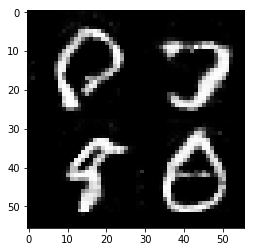

Kierros 902, generator 0.8278946876525879 discriminator 0.9631126523017883
Kierros 904, generator 0.8326537609100342 discriminator 1.0705333948135376
Kierros 906, generator 0.9910206198692322 discriminator 1.054585576057434
Kierros 908, generator 1.2403507232666016 discriminator 0.9491350650787354
Kierros 910, generator 1.2136175632476807 discriminator 1.097367525100708
Kierros 912, generator 1.0595111846923828 discriminator 1.0437496900558472
Kierros 914, generator 1.1795897483825684 discriminator 0.9625053405761719
Kierros 916, generator 1.2546390295028687 discriminator 0.9965370893478394
Kierros 918, generator 0.8179974555969238 discriminator 1.0204914808273315
Kierros 920, generator 0.7678977847099304 discriminator 0.987628698348999
Kierros 922, generator 0.5752196311950684 discriminator 1.2548954486846924
Kierros 924, generator 0.6106085777282715 discriminator 1.0945844650268555
Kierros 926, generator 0.6988654732704163 discriminator 1.047022819519043
Kierros 928, generator 0.8292

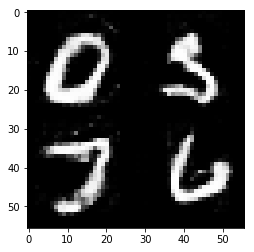

Kierros 952, generator 0.6747291684150696 discriminator 1.145026445388794
Kierros 954, generator 1.0342375040054321 discriminator 1.0302460193634033
Kierros 956, generator 1.099827766418457 discriminator 1.07156503200531
Kierros 958, generator 1.1138966083526611 discriminator 0.9514272212982178
Kierros 960, generator 1.4653164148330688 discriminator 1.084649920463562
Kierros 962, generator 1.2386229038238525 discriminator 1.05778169631958
Kierros 964, generator 1.2558045387268066 discriminator 0.9775471687316895
Kierros 966, generator 1.1506054401397705 discriminator 0.8953416347503662
Kierros 968, generator 0.9161282181739807 discriminator 0.9648832082748413
Kierros 970, generator 1.1384787559509277 discriminator 1.1244672536849976
Kierros 972, generator 1.0640963315963745 discriminator 1.1144336462020874
Kierros 974, generator 1.0802441835403442 discriminator 0.9245941638946533
Kierros 976, generator 1.153225302696228 discriminator 1.0618678331375122
Kierros 978, generator 1.28391075

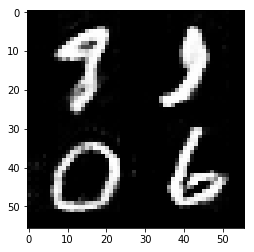

Kierros 1002, generator 1.0685545206069946 discriminator 1.1286485195159912
Kierros 1004, generator 0.8764500021934509 discriminator 1.0020933151245117
Kierros 1006, generator 0.9629981517791748 discriminator 0.9638756513595581
Kierros 1008, generator 0.9758504033088684 discriminator 1.0241129398345947
Kierros 1010, generator 1.0281027555465698 discriminator 0.9079292416572571
Kierros 1012, generator 1.4097087383270264 discriminator 0.9825229644775391
Kierros 1014, generator 1.0050665140151978 discriminator 1.0539212226867676
Kierros 1016, generator 0.9314044117927551 discriminator 0.9933139085769653
Kierros 1018, generator 0.6525249481201172 discriminator 1.1371971368789673
Kierros 1020, generator 0.6524052619934082 discriminator 1.186284065246582
Kierros 1022, generator 0.8748435974121094 discriminator 1.04477858543396
Kierros 1024, generator 0.7894994020462036 discriminator 1.11637544631958
Kierros 1026, generator 0.8126088380813599 discriminator 1.3060760498046875
Kierros 1028, gen

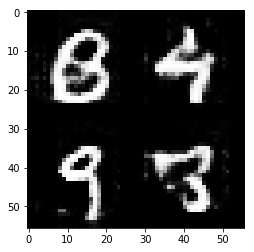

Kierros 1052, generator 0.576882541179657 discriminator 1.1492336988449097
Kierros 1054, generator 0.7280678749084473 discriminator 1.100755214691162
Kierros 1056, generator 0.7496417164802551 discriminator 1.0117487907409668
Kierros 1058, generator 0.7637393474578857 discriminator 0.9762331247329712
Kierros 1060, generator 1.0530833005905151 discriminator 1.1398175954818726
Kierros 1062, generator 1.0023868083953857 discriminator 1.0890315771102905
Kierros 1064, generator 1.1179927587509155 discriminator 0.9577435255050659
Kierros 1066, generator 1.1831607818603516 discriminator 1.024540662765503
Kierros 1068, generator 1.2308335304260254 discriminator 1.071378231048584
Kierros 1070, generator 1.0604963302612305 discriminator 1.0130727291107178
Kierros 1072, generator 0.8227434754371643 discriminator 1.0886489152908325
Kierros 1074, generator 0.7395119667053223 discriminator 1.035691738128662
Kierros 1076, generator 0.8271577954292297 discriminator 1.0044960975646973
Kierros 1078, gen

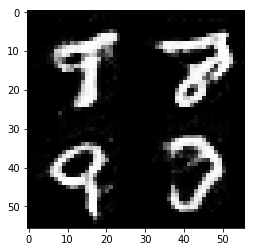

Kierros 1102, generator 1.0545294284820557 discriminator 0.9896857738494873
Kierros 1104, generator 1.1473448276519775 discriminator 1.0388739109039307
Kierros 1106, generator 0.892321765422821 discriminator 1.2056989669799805
Kierros 1108, generator 0.6962874531745911 discriminator 1.1865683794021606
Kierros 1110, generator 0.9929629564285278 discriminator 1.0179177522659302
Kierros 1112, generator 0.8180002570152283 discriminator 1.093000054359436
Kierros 1114, generator 0.840526282787323 discriminator 0.9282538294792175
Kierros 1116, generator 0.8356550335884094 discriminator 0.9813251495361328
Kierros 1118, generator 1.1644805669784546 discriminator 0.9335095286369324
Kierros 1120, generator 1.1985254287719727 discriminator 1.1478614807128906
Kierros 1122, generator 1.593747615814209 discriminator 1.3812222480773926
Kierros 1124, generator 1.3859202861785889 discriminator 1.1217310428619385
Kierros 1126, generator 0.9135602712631226 discriminator 1.1625728607177734
Kierros 1128, ge

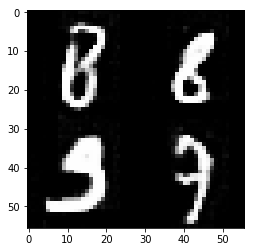

Kierros 1152, generator 0.46533796191215515 discriminator 1.3003429174423218
Kierros 1154, generator 0.5995659232139587 discriminator 1.13479483127594
Kierros 1156, generator 0.7071152329444885 discriminator 1.090852975845337
Kierros 1158, generator 0.9372289180755615 discriminator 0.9570484161376953
Kierros 1160, generator 1.008102536201477 discriminator 0.9494643807411194
Kierros 1162, generator 0.9948798418045044 discriminator 0.948417067527771
Kierros 1164, generator 1.21225905418396 discriminator 1.0158624649047852
Kierros 1166, generator 1.0432829856872559 discriminator 1.1291639804840088
Kierros 1168, generator 1.171162486076355 discriminator 1.0794216394424438
Kierros 1170, generator 1.17832350730896 discriminator 1.1679638624191284
Kierros 1172, generator 0.7770504951477051 discriminator 1.076986312866211
Kierros 1174, generator 0.5734078884124756 discriminator 1.1501866579055786
Kierros 1176, generator 0.8137209415435791 discriminator 1.101288914680481
Kierros 1178, generator

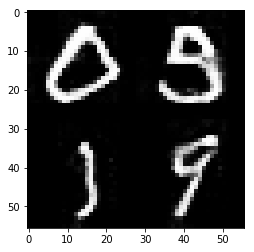

Kierros 1202, generator 0.8423444628715515 discriminator 1.0528236627578735
Kierros 1204, generator 0.7024322152137756 discriminator 1.0951288938522339
Kierros 1206, generator 0.8759369254112244 discriminator 1.1785430908203125
Kierros 1208, generator 0.9524840712547302 discriminator 1.3303234577178955
Kierros 1210, generator 1.02001953125 discriminator 1.309072494506836
Kierros 1212, generator 0.7659708261489868 discriminator 1.222792148590088
Kierros 1214, generator 0.9444336295127869 discriminator 1.1059887409210205
Kierros 1216, generator 1.2172883749008179 discriminator 1.118499755859375
Kierros 1218, generator 1.1585073471069336 discriminator 1.047516942024231
Kierros 1220, generator 0.7720960378646851 discriminator 1.0956008434295654
Kierros 1222, generator 0.9048700928688049 discriminator 1.1615779399871826
Kierros 1224, generator 0.8566477298736572 discriminator 1.0945262908935547
Kierros 1226, generator 0.8161201477050781 discriminator 0.9802947044372559
Kierros 1228, generat

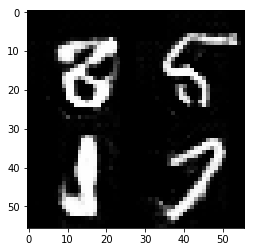

Kierros 1252, generator 1.1903655529022217 discriminator 1.1748650074005127
Kierros 1254, generator 1.1583436727523804 discriminator 1.1329617500305176
Kierros 1256, generator 1.3280603885650635 discriminator 1.1063175201416016
Kierros 1258, generator 1.0784412622451782 discriminator 1.1811738014221191
Kierros 1260, generator 1.0509713888168335 discriminator 1.0690494775772095
Kierros 1262, generator 1.2246766090393066 discriminator 1.1303060054779053
Kierros 1264, generator 1.0242915153503418 discriminator 0.9893515110015869
Kierros 1266, generator 0.9163522720336914 discriminator 1.1614655256271362
Kierros 1268, generator 0.5443241596221924 discriminator 1.2880973815917969
Kierros 1270, generator 0.48010993003845215 discriminator 1.3153443336486816
Kierros 1272, generator 0.6982654929161072 discriminator 1.1101354360580444
Kierros 1274, generator 0.7196090221405029 discriminator 1.1471374034881592
Kierros 1276, generator 0.8586277365684509 discriminator 1.0611718893051147
Kierros 127

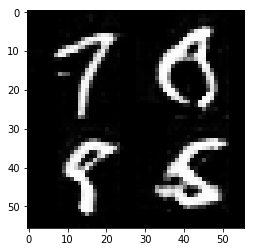

Kierros 1302, generator 0.9675604104995728 discriminator 1.2857630252838135
Kierros 1304, generator 0.8965989947319031 discriminator 1.30332612991333
Kierros 1306, generator 1.0762449502944946 discriminator 1.023491621017456
Kierros 1308, generator 1.0091575384140015 discriminator 1.0216350555419922
Kierros 1310, generator 0.9627176523208618 discriminator 1.0135804414749146
Kierros 1312, generator 0.7588381767272949 discriminator 1.1896567344665527
Kierros 1314, generator 0.8158923387527466 discriminator 1.1472110748291016
Kierros 1316, generator 0.8757457137107849 discriminator 1.004143238067627
Kierros 1318, generator 0.7921455502510071 discriminator 1.0628128051757812
Kierros 1320, generator 0.8166468143463135 discriminator 1.0299110412597656
Kierros 1322, generator 0.838148832321167 discriminator 1.1515074968338013
Kierros 1324, generator 0.8674659132957458 discriminator 1.2052364349365234
Kierros 1326, generator 0.8280143141746521 discriminator 1.183371901512146
Kierros 1328, gene

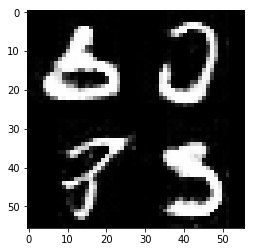

Kierros 1352, generator 0.8552709221839905 discriminator 1.0688965320587158
Kierros 1354, generator 0.8004550337791443 discriminator 1.1371508836746216
Kierros 1356, generator 0.857546329498291 discriminator 1.1537654399871826
Kierros 1358, generator 0.8399159908294678 discriminator 1.1180914640426636
Kierros 1360, generator 0.7291361689567566 discriminator 1.155625343322754
Kierros 1362, generator 0.7240455150604248 discriminator 1.0978772640228271
Kierros 1364, generator 1.0553678274154663 discriminator 1.0236380100250244
Kierros 1366, generator 0.7722119688987732 discriminator 1.0733850002288818
Kierros 1368, generator 0.6659059524536133 discriminator 1.1275794506072998
Kierros 1370, generator 0.6906489729881287 discriminator 1.1401962041854858
Kierros 1372, generator 0.660963237285614 discriminator 1.2265560626983643
Kierros 1374, generator 0.7855133414268494 discriminator 1.334822416305542
Kierros 1376, generator 0.9366310834884644 discriminator 1.124495267868042
Kierros 1378, gen

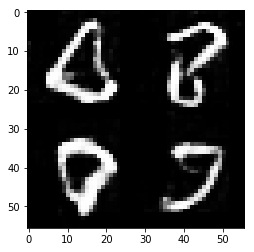

Kierros 1402, generator 0.7453402876853943 discriminator 1.137534737586975
Kierros 1404, generator 0.6499882340431213 discriminator 1.2377431392669678
Kierros 1406, generator 0.5032652020454407 discriminator 1.2465118169784546
Kierros 1408, generator 0.5714677572250366 discriminator 1.167479157447815
Kierros 1410, generator 1.2285083532333374 discriminator 1.1194064617156982
Kierros 1412, generator 1.1632106304168701 discriminator 1.1846442222595215
Kierros 1414, generator 0.9296709895133972 discriminator 1.060051441192627
Kierros 1416, generator 1.3438645601272583 discriminator 1.2176669836044312
Kierros 1418, generator 1.3715219497680664 discriminator 1.1975305080413818
Kierros 1420, generator 1.3852646350860596 discriminator 1.0879459381103516
Kierros 1422, generator 1.2408174276351929 discriminator 1.0990405082702637
Kierros 1424, generator 0.9977824687957764 discriminator 1.3947392702102661
Kierros 1426, generator 0.9929850101470947 discriminator 1.3959012031555176
Kierros 1428, g

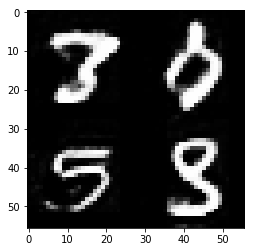

Kierros 1452, generator 0.7005975842475891 discriminator 1.2809464931488037
Kierros 1454, generator 1.089914321899414 discriminator 1.290480375289917
Kierros 1456, generator 1.1211060285568237 discriminator 1.2575335502624512
Kierros 1458, generator 0.9784638285636902 discriminator 1.1141821146011353
Kierros 1460, generator 0.9182045459747314 discriminator 1.0891951322555542
Kierros 1462, generator 1.08993399143219 discriminator 1.3947510719299316
Kierros 1464, generator 1.1839300394058228 discriminator 1.239186406135559
Kierros 1466, generator 0.9880599975585938 discriminator 1.0953631401062012
Kierros 1468, generator 0.9869349598884583 discriminator 1.1708970069885254
Kierros 1470, generator 0.9402018189430237 discriminator 1.0061280727386475
Kierros 1472, generator 0.8333669304847717 discriminator 1.098883032798767
Kierros 1474, generator 0.8340721130371094 discriminator 1.1560252904891968
Kierros 1476, generator 0.9357525706291199 discriminator 1.113495111465454
Kierros 1478, gener

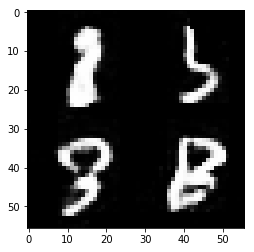

Kierros 1502, generator 0.6179372072219849 discriminator 1.2201858758926392
Kierros 1504, generator 0.9054222702980042 discriminator 1.0612163543701172
Kierros 1506, generator 0.838259220123291 discriminator 1.0680828094482422
Kierros 1508, generator 0.7442421913146973 discriminator 1.2124967575073242
Kierros 1510, generator 0.5925337672233582 discriminator 1.2251511812210083
Kierros 1512, generator 0.4581384062767029 discriminator 1.4640244245529175
Kierros 1514, generator 0.7423784136772156 discriminator 1.0897068977355957
Kierros 1516, generator 0.780737578868866 discriminator 1.1288098096847534
Kierros 1518, generator 0.8594456911087036 discriminator 1.2521427869796753
Kierros 1520, generator 0.5947977304458618 discriminator 1.300328254699707
Kierros 1522, generator 0.5292984247207642 discriminator 1.3015103340148926
Kierros 1524, generator 0.6837989091873169 discriminator 1.1056939363479614
Kierros 1526, generator 0.8597663640975952 discriminator 1.0171304941177368
Kierros 1528, g

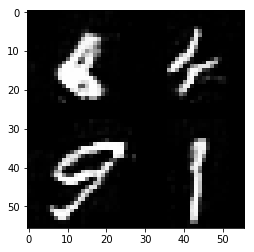

Kierros 1552, generator 0.665169358253479 discriminator 1.1744439601898193
Kierros 1554, generator 0.764673113822937 discriminator 1.0209535360336304
Kierros 1556, generator 0.8490602374076843 discriminator 1.0210837125778198
Kierros 1558, generator 0.6217030882835388 discriminator 1.1826622486114502
Kierros 1560, generator 0.6546631455421448 discriminator 1.2086057662963867
Kierros 1562, generator 0.8951985239982605 discriminator 1.0248587131500244
Kierros 1564, generator 0.7733908891677856 discriminator 1.1859569549560547
Kierros 1566, generator 0.6060216426849365 discriminator 1.1414333581924438
Kierros 1568, generator 0.5847266316413879 discriminator 1.2069740295410156
Kierros 1570, generator 0.45821940898895264 discriminator 1.3319510221481323
Kierros 1572, generator 0.5212116837501526 discriminator 1.2830955982208252
Kierros 1574, generator 0.980177104473114 discriminator 1.0756232738494873
Kierros 1576, generator 1.081886887550354 discriminator 1.234279751777649
Kierros 1578, ge

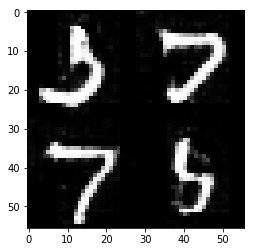

Kierros 1602, generator 1.110844612121582 discriminator 1.0502464771270752
Kierros 1604, generator 0.8267690539360046 discriminator 0.9898879528045654
Kierros 1606, generator 0.8495973348617554 discriminator 0.9762201905250549
Kierros 1608, generator 0.7004350423812866 discriminator 1.09324049949646
Kierros 1610, generator 1.0178993940353394 discriminator 1.0594100952148438
Kierros 1612, generator 0.8094863891601562 discriminator 1.1416642665863037
Kierros 1614, generator 0.9189086556434631 discriminator 1.300011396408081
Kierros 1616, generator 0.5389031171798706 discriminator 1.2463699579238892
Kierros 1618, generator 0.5017157196998596 discriminator 1.3293657302856445
Kierros 1620, generator 0.895682692527771 discriminator 1.1181871891021729
Kierros 1622, generator 0.7181121110916138 discriminator 1.3342218399047852
Kierros 1624, generator 0.645021915435791 discriminator 1.148523211479187
Kierros 1626, generator 0.5796157121658325 discriminator 1.1708130836486816
Kierros 1628, gener

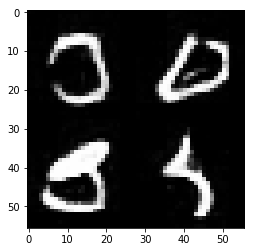

Kierros 1652, generator 0.9477087259292603 discriminator 1.223827600479126
Kierros 1654, generator 0.6184876561164856 discriminator 1.237062931060791
Kierros 1656, generator 1.2679200172424316 discriminator 1.091408610343933
Kierros 1658, generator 1.06990647315979 discriminator 1.2349462509155273
Kierros 1660, generator 0.9317687749862671 discriminator 1.1343724727630615
Kierros 1662, generator 0.9249911308288574 discriminator 1.1043362617492676
Kierros 1664, generator 1.1801514625549316 discriminator 1.085676670074463
Kierros 1666, generator 1.266836404800415 discriminator 1.0806245803833008
Kierros 1668, generator 0.9502924680709839 discriminator 1.1815462112426758
Kierros 1670, generator 0.7499387264251709 discriminator 1.1421682834625244
Kierros 1672, generator 0.7358909249305725 discriminator 1.043198585510254
Kierros 1674, generator 0.7270429134368896 discriminator 1.0947996377944946
Kierros 1676, generator 0.806911051273346 discriminator 1.1030759811401367
Kierros 1678, generat

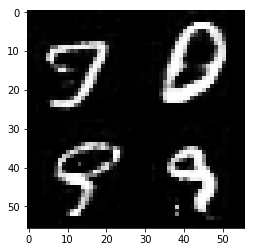

Kierros 1702, generator 1.429447054862976 discriminator 1.147996425628662
Kierros 1704, generator 1.2135443687438965 discriminator 1.2451976537704468
Kierros 1706, generator 1.2666740417480469 discriminator 1.3168593645095825
Kierros 1708, generator 0.6310545802116394 discriminator 1.1896378993988037
Kierros 1710, generator 0.6977953910827637 discriminator 1.2047085762023926
Kierros 1712, generator 1.0247641801834106 discriminator 1.0604705810546875
Kierros 1714, generator 1.252183198928833 discriminator 1.2902069091796875
Kierros 1716, generator 0.9013129472732544 discriminator 1.09706449508667
Kierros 1718, generator 0.5154292583465576 discriminator 1.3570195436477661
Kierros 1720, generator 0.6627787351608276 discriminator 1.0941874980926514
Kierros 1722, generator 0.969606339931488 discriminator 1.1461646556854248
Kierros 1724, generator 1.0962064266204834 discriminator 1.1628299951553345
Kierros 1726, generator 0.8142184615135193 discriminator 1.119933843612671
Kierros 1728, gener

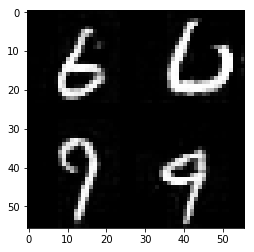

Kierros 1752, generator 0.6815493702888489 discriminator 1.124971866607666
Kierros 1754, generator 0.649507999420166 discriminator 1.199436902999878
Kierros 1756, generator 0.7101094722747803 discriminator 1.248758316040039
Kierros 1758, generator 0.7003310322761536 discriminator 1.2505780458450317
Kierros 1760, generator 0.905846893787384 discriminator 1.286692500114441
Kierros 1762, generator 1.0984408855438232 discriminator 1.2465081214904785
Kierros 1764, generator 0.9371174573898315 discriminator 1.2272039651870728
Kierros 1766, generator 0.8082631230354309 discriminator 1.249050498008728
Kierros 1768, generator 0.6384565234184265 discriminator 1.1400105953216553
Kierros 1770, generator 0.7764147520065308 discriminator 1.0554747581481934
Kierros 1772, generator 0.9327757954597473 discriminator 1.1020762920379639
Kierros 1774, generator 1.0443212985992432 discriminator 1.2932820320129395
Kierros 1776, generator 0.9240440726280212 discriminator 1.2357494831085205
Kierros 1778, gener

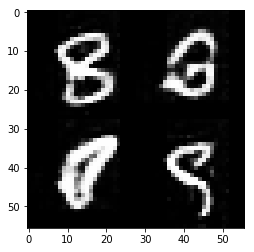

Kierros 1802, generator 0.7672891616821289 discriminator 1.0639934539794922
Kierros 1804, generator 1.071286678314209 discriminator 1.038523554801941
Kierros 1806, generator 0.9696283340454102 discriminator 1.4552881717681885
Kierros 1808, generator 1.0144962072372437 discriminator 1.179053544998169
Kierros 1810, generator 0.9120229482650757 discriminator 1.1708111763000488
Kierros 1812, generator 0.8396652340888977 discriminator 1.113412857055664
Kierros 1814, generator 0.7836977243423462 discriminator 1.1195358037948608
Kierros 1816, generator 0.7314603924751282 discriminator 1.145456314086914
Kierros 1818, generator 1.0486094951629639 discriminator 1.1242461204528809
Kierros 1820, generator 0.815645694732666 discriminator 1.2260774374008179
Kierros 1822, generator 0.9382113814353943 discriminator 1.0774827003479004
Kierros 1824, generator 0.928840160369873 discriminator 1.1279317140579224
Kierros 1826, generator 1.1174287796020508 discriminator 1.1703693866729736
Kierros 1828, gener

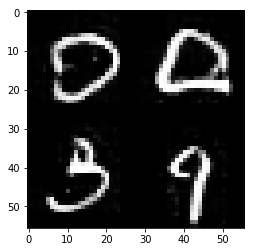

Kierros 1852, generator 0.6555837392807007 discriminator 1.456913709640503
Kierros 1854, generator 0.9439206719398499 discriminator 0.977173924446106
Kierros 1856, generator 1.0495119094848633 discriminator 1.0634217262268066
Kierros 1858, generator 0.9454775452613831 discriminator 1.069593906402588
Kierros 1860, generator 1.0010738372802734 discriminator 1.0710694789886475
Kierros 1862, generator 1.0310306549072266 discriminator 1.1252864599227905
Kierros 1864, generator 1.1800459623336792 discriminator 1.0359416007995605
Kierros 1866, generator 0.9690290689468384 discriminator 1.1691491603851318
Kierros 1868, generator 0.9432430863380432 discriminator 0.9578627347946167
Kierros 1870, generator 0.769278883934021 discriminator 1.120863914489746
Kierros 1872, generator 0.42440658807754517 discriminator 1.4471981525421143
Kierros 1874, generator 0.55293208360672 discriminator 1.2464481592178345
Epoch 1!


KeyboardInterrupt: 

In [40]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Kierros 2, generator 1.0118157863616943 discriminator 3.3243355751037598
Kierros 4, generator 1.2282359600067139 discriminator 1.4175093173980713
Kierros 6, generator 1.0127942562103271 discriminator 0.9368195533752441
Kierros 8, generator 1.1829453706741333 discriminator 0.7788907289505005
Kierros 10, generator 1.2030394077301025 discriminator 0.6656454801559448
Kierros 12, generator 1.3134404420852661 discriminator 0.6265504360198975
Kierros 14, generator 1.5828828811645508 discriminator 0.7963665723800659
Kierros 16, generator 1.6617814302444458 discriminator 0.7222132682800293
Kierros 18, generator 1.4232993125915527 discriminator 0.5789067149162292
Kierros 20, generator 2.0493507385253906 discriminator 0.38485366106033325
Kierros 22, generator 1.9578754901885986 discriminator 0.2922819256782532
Kierros 24, generator 2.249936580657959 discriminator 0.2486095279455185
Kierros 26, generator 2.5349457263946533 discriminator 0.20675164461135864
Kierros 28, generator 2.1317780017852783 

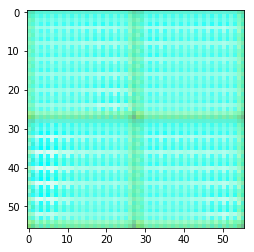

Kierros 52, generator 2.1207094192504883 discriminator 0.9832651615142822
Kierros 54, generator 1.4244383573532104 discriminator 0.8403558731079102
Kierros 56, generator 1.1149061918258667 discriminator 0.8839467763900757
Kierros 58, generator 0.9121317267417908 discriminator 0.9464213848114014
Kierros 60, generator 0.46355554461479187 discriminator 1.8658186197280884
Kierros 62, generator 2.0149264335632324 discriminator 0.814324140548706
Kierros 64, generator 1.4982483386993408 discriminator 0.44598451256752014
Kierros 66, generator 1.8989866971969604 discriminator 0.3569573760032654
Kierros 68, generator 1.9993128776550293 discriminator 0.3014093041419983
Kierros 70, generator 1.9453065395355225 discriminator 0.3031443953514099
Kierros 72, generator 2.1301028728485107 discriminator 0.2939479947090149
Kierros 74, generator 2.124025344848633 discriminator 0.29819226264953613
Kierros 76, generator 2.1835598945617676 discriminator 0.2800089120864868
Kierros 78, generator 1.4758597612380

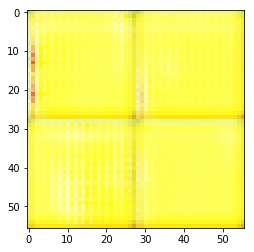

Kierros 102, generator 2.4846737384796143 discriminator 0.19807344675064087
Kierros 104, generator 2.2871620655059814 discriminator 0.22763991355895996
Kierros 106, generator 2.1325109004974365 discriminator 0.22783741354942322
Kierros 108, generator 3.3653652667999268 discriminator 1.207881212234497
Kierros 110, generator 1.4201756715774536 discriminator 1.9747157096862793
Kierros 112, generator 2.4710018634796143 discriminator 0.3889369070529938
Kierros 114, generator 1.2233575582504272 discriminator 0.5478571057319641
Kierros 116, generator 0.4412806034088135 discriminator 1.4595073461532593
Kierros 118, generator 2.0104753971099854 discriminator 2.452148675918579
Kierros 120, generator 1.8100324869155884 discriminator 0.6686184406280518
Kierros 122, generator 1.629071593284607 discriminator 0.6718924045562744
Kierros 124, generator 2.564218521118164 discriminator 0.8534001708030701
Kierros 126, generator 2.6441409587860107 discriminator 1.8583122491836548
Kierros 128, generator 0.8

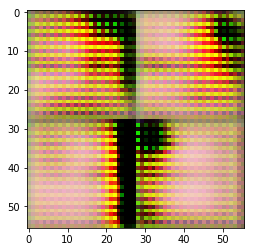

Kierros 152, generator 1.7964849472045898 discriminator 0.6328113675117493
Kierros 154, generator 0.9900681376457214 discriminator 0.8833428025245667
Kierros 156, generator 0.5116469264030457 discriminator 1.3303170204162598
Kierros 158, generator 0.4015304446220398 discriminator 1.6533020734786987
Kierros 160, generator 0.34700238704681396 discriminator 1.7203236818313599
Kierros 162, generator 0.7098746299743652 discriminator 1.2212165594100952
Kierros 164, generator 1.0107260942459106 discriminator 1.0366458892822266
Kierros 166, generator 1.0091851949691772 discriminator 0.8529309034347534
Kierros 168, generator 1.0776132345199585 discriminator 0.9107275009155273
Kierros 170, generator 1.5025397539138794 discriminator 1.4392831325531006
Kierros 172, generator 0.7149226069450378 discriminator 1.3762001991271973
Kierros 174, generator 0.5503842830657959 discriminator 1.1946961879730225
Kierros 176, generator 1.0473527908325195 discriminator 1.1370978355407715
Kierros 178, generator 1

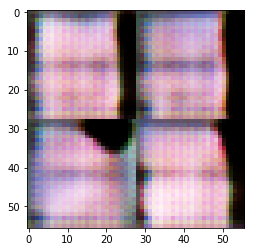

Kierros 202, generator 0.41410425305366516 discriminator 1.7664053440093994
Kierros 204, generator 1.2459142208099365 discriminator 1.3113975524902344
Kierros 206, generator 0.6826103329658508 discriminator 1.167743444442749
Kierros 208, generator 1.0846123695373535 discriminator 0.9348218441009521
Kierros 210, generator 1.0060749053955078 discriminator 0.9017889499664307
Kierros 212, generator 1.0277212858200073 discriminator 0.9261559247970581
Kierros 214, generator 1.365776538848877 discriminator 1.3163570165634155
Kierros 216, generator 0.630638837814331 discriminator 1.2399308681488037
Kierros 218, generator 0.9455133676528931 discriminator 0.8273305892944336
Kierros 220, generator 1.6603200435638428 discriminator 0.9728363752365112
Kierros 222, generator 0.8856446146965027 discriminator 1.3156508207321167
Kierros 224, generator 0.6552985310554504 discriminator 1.158268690109253
Kierros 226, generator 0.7214343547821045 discriminator 1.3329508304595947
Kierros 228, generator 0.599

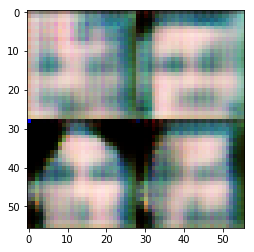

Kierros 252, generator 0.746645450592041 discriminator 1.3384534120559692
Kierros 254, generator 0.9436085224151611 discriminator 1.3807733058929443
Kierros 256, generator 1.016579270362854 discriminator 0.9491197466850281
Kierros 258, generator 1.1078766584396362 discriminator 1.4612042903900146
Kierros 260, generator 0.9058514833450317 discriminator 1.0507142543792725
Kierros 262, generator 1.0178290605545044 discriminator 1.5914146900177002
Kierros 264, generator 1.0588326454162598 discriminator 1.0662970542907715
Kierros 266, generator 0.5053489208221436 discriminator 1.4269295930862427
Kierros 268, generator 0.824916422367096 discriminator 1.2184438705444336
Kierros 270, generator 1.1386196613311768 discriminator 1.592369794845581
Kierros 272, generator 0.7168950438499451 discriminator 1.3538892269134521
Kierros 274, generator 0.7274909019470215 discriminator 1.3511285781860352
Kierros 276, generator 0.8239285945892334 discriminator 1.472217321395874
Kierros 278, generator 0.72175

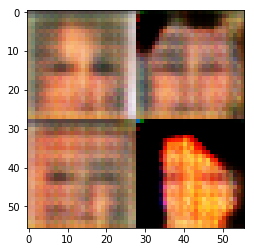

Kierros 302, generator 0.8162634968757629 discriminator 1.0641961097717285
Kierros 304, generator 0.9232739210128784 discriminator 1.294684886932373
Kierros 306, generator 0.9711236953735352 discriminator 1.5962042808532715
Kierros 308, generator 0.7790343761444092 discriminator 1.3208798170089722
Kierros 310, generator 0.7836745977401733 discriminator 1.4391138553619385
Kierros 312, generator 0.49458080530166626 discriminator 1.5176860094070435
Kierros 314, generator 0.8848490715026855 discriminator 1.2634413242340088
Kierros 316, generator 0.8944895267486572 discriminator 1.2484527826309204
Kierros 318, generator 0.9816418886184692 discriminator 1.4820282459259033
Kierros 320, generator 0.6706314086914062 discriminator 1.238757848739624
Kierros 322, generator 1.0515837669372559 discriminator 0.9409990310668945
Kierros 324, generator 1.2263975143432617 discriminator 1.0168429613113403
Kierros 326, generator 0.7998142838478088 discriminator 1.1403160095214844
Kierros 328, generator 0.8

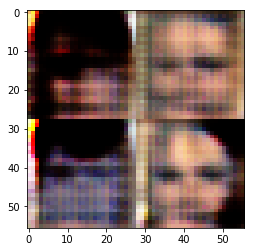

Kierros 352, generator 0.778180718421936 discriminator 1.0497159957885742
Kierros 354, generator 0.6481081247329712 discriminator 1.3189396858215332
Kierros 356, generator 0.8132318258285522 discriminator 1.355684518814087
Kierros 358, generator 0.7774405479431152 discriminator 1.284602403640747
Kierros 360, generator 0.5514013171195984 discriminator 1.5141046047210693
Kierros 362, generator 0.6173782348632812 discriminator 1.6021966934204102
Kierros 364, generator 0.7368589043617249 discriminator 1.4797792434692383
Kierros 366, generator 0.9897211790084839 discriminator 1.3831936120986938
Kierros 368, generator 0.770790159702301 discriminator 1.227715015411377
Kierros 370, generator 0.6663795113563538 discriminator 1.1857253313064575
Kierros 372, generator 0.7958924174308777 discriminator 1.3572051525115967
Kierros 374, generator 0.6683110594749451 discriminator 1.5023183822631836
Kierros 376, generator 0.7264330387115479 discriminator 1.274982213973999
Kierros 378, generator 1.003249

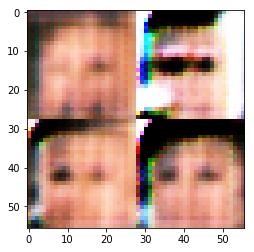

Kierros 402, generator 0.6459013223648071 discriminator 1.3288615942001343
Kierros 404, generator 0.8151580691337585 discriminator 1.6677589416503906
Kierros 406, generator 0.8639317154884338 discriminator 1.5661895275115967
Kierros 408, generator 0.6015146970748901 discriminator 1.5130512714385986
Kierros 410, generator 0.7743684649467468 discriminator 1.174826979637146
Kierros 412, generator 0.7599709033966064 discriminator 1.2860751152038574
Kierros 414, generator 0.7219418883323669 discriminator 1.6125340461730957
Kierros 416, generator 0.7647829651832581 discriminator 1.3584128618240356
Kierros 418, generator 0.8275912404060364 discriminator 1.189287781715393
Kierros 420, generator 0.721208930015564 discriminator 1.3123795986175537
Kierros 422, generator 0.8981195688247681 discriminator 1.1781606674194336
Kierros 424, generator 0.6355438232421875 discriminator 1.3188302516937256
Kierros 426, generator 0.755795955657959 discriminator 1.2983219623565674
Kierros 428, generator 0.9702

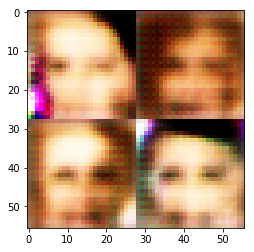

Kierros 452, generator 0.8247490525245667 discriminator 1.3405003547668457
Kierros 454, generator 0.7776708602905273 discriminator 1.2877840995788574
Kierros 456, generator 0.8675554990768433 discriminator 1.357940435409546
Kierros 458, generator 0.7999629378318787 discriminator 1.2505812644958496
Kierros 460, generator 0.5726538896560669 discriminator 1.233514428138733
Kierros 462, generator 0.8236865401268005 discriminator 1.1079505681991577
Kierros 464, generator 0.9491174817085266 discriminator 1.1145782470703125
Kierros 466, generator 0.8558688163757324 discriminator 1.1948769092559814
Kierros 468, generator 0.7951015830039978 discriminator 1.3654199838638306
Kierros 470, generator 0.7928491830825806 discriminator 1.305525541305542
Kierros 472, generator 0.6258176565170288 discriminator 1.269859790802002
Kierros 474, generator 0.684293806552887 discriminator 1.1210800409317017
Kierros 476, generator 0.9648159742355347 discriminator 1.0898425579071045
Kierros 478, generator 0.85205

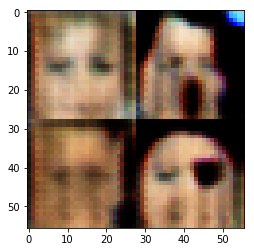

Kierros 502, generator 0.572437584400177 discriminator 1.3800145387649536
Kierros 504, generator 0.5697998404502869 discriminator 1.5353550910949707
Kierros 506, generator 1.0224961042404175 discriminator 1.2736297845840454
Kierros 508, generator 0.9509617686271667 discriminator 1.0851869583129883
Kierros 510, generator 0.5861650109291077 discriminator 1.264532446861267
Kierros 512, generator 0.8076597452163696 discriminator 0.975480854511261
Kierros 514, generator 0.8500669598579407 discriminator 1.0481268167495728
Kierros 516, generator 0.8090072274208069 discriminator 1.282716989517212
Kierros 518, generator 0.5953443646430969 discriminator 1.63615083694458
Kierros 520, generator 1.0173405408859253 discriminator 1.384481430053711
Kierros 522, generator 1.0182932615280151 discriminator 1.3338427543640137
Kierros 524, generator 0.9202234745025635 discriminator 1.2404168844223022
Kierros 526, generator 0.8254038691520691 discriminator 1.1371781826019287
Kierros 528, generator 0.7145837

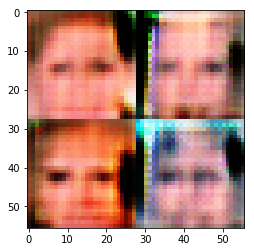

Kierros 552, generator 0.6529656648635864 discriminator 1.166395902633667
Kierros 554, generator 0.8580700755119324 discriminator 1.120869517326355
Kierros 556, generator 1.0048983097076416 discriminator 1.263155221939087
Kierros 558, generator 0.9102929830551147 discriminator 1.282015085220337
Kierros 560, generator 0.6129295825958252 discriminator 1.597170352935791
Kierros 562, generator 0.8351563215255737 discriminator 1.2493438720703125
Kierros 564, generator 1.1509660482406616 discriminator 0.9833391308784485
Kierros 566, generator 0.8089792132377625 discriminator 1.1646281480789185
Kierros 568, generator 0.8908028602600098 discriminator 1.035493016242981
Kierros 570, generator 1.1690282821655273 discriminator 1.3412299156188965
Kierros 572, generator 1.1395378112792969 discriminator 1.2606991529464722
Kierros 574, generator 1.355887770652771 discriminator 1.4384901523590088
Kierros 576, generator 0.9766889214515686 discriminator 1.4623470306396484
Kierros 578, generator 0.9416649

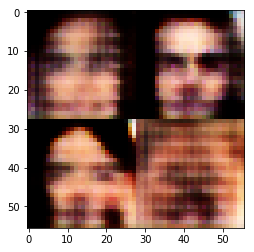

Kierros 602, generator 0.7146728038787842 discriminator 1.2456642389297485
Kierros 604, generator 0.7098117470741272 discriminator 1.21675443649292
Kierros 606, generator 0.8741053342819214 discriminator 1.1762655973434448
Kierros 608, generator 0.8531320691108704 discriminator 1.3315682411193848
Kierros 610, generator 0.7736470699310303 discriminator 1.2882299423217773
Kierros 612, generator 0.8278278708457947 discriminator 1.506980061531067
Kierros 614, generator 0.952747642993927 discriminator 1.376033067703247
Kierros 616, generator 0.9888564944267273 discriminator 1.2145380973815918
Kierros 618, generator 0.8216530680656433 discriminator 1.1016182899475098
Kierros 620, generator 0.5886395573616028 discriminator 1.2095849514007568
Kierros 622, generator 0.8749868273735046 discriminator 1.1700987815856934
Kierros 624, generator 0.6035646200180054 discriminator 1.5666677951812744
Kierros 626, generator 0.8046262264251709 discriminator 1.3954548835754395
Kierros 628, generator 0.75919

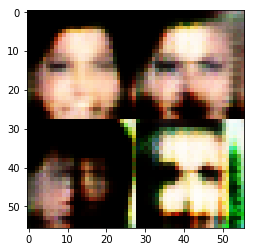

Kierros 652, generator 0.7620835304260254 discriminator 1.2313876152038574
Kierros 654, generator 0.6581870317459106 discriminator 1.4004359245300293
Kierros 656, generator 0.6414144039154053 discriminator 1.3448396921157837
Kierros 658, generator 0.5616717338562012 discriminator 1.4422067403793335
Kierros 660, generator 1.0349547863006592 discriminator 1.237660527229309
Kierros 662, generator 0.6550503969192505 discriminator 1.331857681274414
Kierros 664, generator 0.9166129231452942 discriminator 1.0834403038024902
Kierros 666, generator 0.6947126388549805 discriminator 1.2280775308609009
Kierros 668, generator 0.6364979147911072 discriminator 1.3613747358322144
Kierros 670, generator 0.4816839396953583 discriminator 1.37527596950531
Kierros 672, generator 0.7132299542427063 discriminator 1.2345954179763794
Kierros 674, generator 0.73560631275177 discriminator 1.2533795833587646
Kierros 676, generator 0.5357413291931152 discriminator 1.3475143909454346
Kierros 678, generator 0.799335

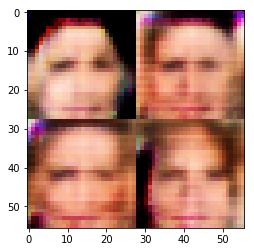

Kierros 702, generator 0.7611712217330933 discriminator 1.2956609725952148
Kierros 704, generator 0.6367058157920837 discriminator 1.3947038650512695
Kierros 706, generator 0.6555082201957703 discriminator 1.441365122795105
Kierros 708, generator 0.5695784687995911 discriminator 1.3691856861114502
Kierros 710, generator 0.864068329334259 discriminator 1.0485551357269287
Kierros 712, generator 0.6712189316749573 discriminator 1.2895362377166748
Kierros 714, generator 0.662492573261261 discriminator 1.2807992696762085
Kierros 716, generator 0.5945560932159424 discriminator 1.3764407634735107
Kierros 718, generator 0.558738648891449 discriminator 1.343339443206787
Kierros 720, generator 0.9613205790519714 discriminator 1.0810701847076416
Kierros 722, generator 0.8031883239746094 discriminator 1.4794145822525024
Kierros 724, generator 0.9557501077651978 discriminator 1.2375068664550781
Kierros 726, generator 0.6388017535209656 discriminator 1.3535833358764648
Kierros 728, generator 0.67918

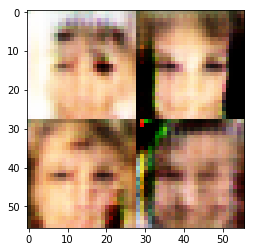

Kierros 752, generator 0.7243776917457581 discriminator 1.288545846939087
Kierros 754, generator 0.6207310557365417 discriminator 1.3893167972564697
Kierros 756, generator 0.6303130388259888 discriminator 1.2583215236663818
Kierros 758, generator 0.8195014595985413 discriminator 1.190930724143982
Kierros 760, generator 0.7917187809944153 discriminator 1.1986398696899414
Kierros 762, generator 0.9613924026489258 discriminator 1.1524009704589844
Kierros 764, generator 0.5881401896476746 discriminator 1.4360392093658447
Kierros 766, generator 0.6724894046783447 discriminator 1.2620370388031006
Kierros 768, generator 0.8594727516174316 discriminator 1.2784841060638428
Kierros 770, generator 0.9433748722076416 discriminator 1.1535236835479736
Kierros 772, generator 0.6972041130065918 discriminator 1.2757328748703003
Kierros 774, generator 0.4981090724468231 discriminator 1.4459744691848755
Kierros 776, generator 0.955771803855896 discriminator 1.3395873308181763
Kierros 778, generator 0.759

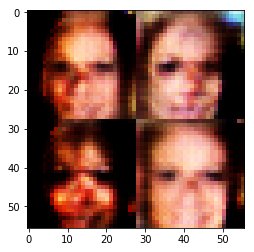

Kierros 802, generator 0.8295506834983826 discriminator 1.201122760772705
Kierros 804, generator 0.8564601540565491 discriminator 1.458913803100586
Kierros 806, generator 0.7543044686317444 discriminator 1.195299506187439
Kierros 808, generator 0.8253384232521057 discriminator 1.1739439964294434
Kierros 810, generator 0.6511654853820801 discriminator 1.3148612976074219
Kierros 812, generator 0.9184662103652954 discriminator 1.314554214477539
Kierros 814, generator 1.0618728399276733 discriminator 1.2245663404464722
Kierros 816, generator 0.7714438438415527 discriminator 1.095834732055664
Kierros 818, generator 0.5751670002937317 discriminator 1.1667377948760986
Kierros 820, generator 0.8668649792671204 discriminator 1.0177936553955078
Kierros 822, generator 0.5164911150932312 discriminator 1.364394187927246
Kierros 824, generator 1.0987184047698975 discriminator 1.431470274925232
Kierros 826, generator 1.1825780868530273 discriminator 1.8447970151901245
Kierros 828, generator 0.8544825

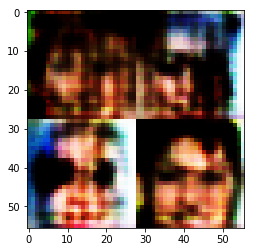

Kierros 852, generator 0.7004111409187317 discriminator 1.2504217624664307
Kierros 854, generator 0.9186279773712158 discriminator 1.4123854637145996
Kierros 856, generator 0.8256382942199707 discriminator 1.2575178146362305
Kierros 858, generator 0.7853143811225891 discriminator 1.2172361612319946
Kierros 860, generator 0.7290112376213074 discriminator 1.4044417142868042
Kierros 862, generator 0.519811749458313 discriminator 1.4487431049346924
Kierros 864, generator 0.8133029341697693 discriminator 1.2324718236923218
Kierros 866, generator 0.6547655463218689 discriminator 1.1108022928237915
Kierros 868, generator 0.5788246989250183 discriminator 1.2744847536087036
Kierros 870, generator 0.9816863536834717 discriminator 1.0160584449768066
Kierros 872, generator 1.081202745437622 discriminator 1.339331865310669
Kierros 874, generator 0.7493928670883179 discriminator 1.5077869892120361
Kierros 876, generator 0.8493512272834778 discriminator 1.3336095809936523
Kierros 878, generator 0.784

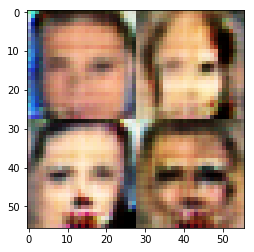

Kierros 902, generator 0.6978104114532471 discriminator 1.102081298828125
Kierros 904, generator 0.5811178088188171 discriminator 1.3146051168441772
Kierros 906, generator 0.7266440391540527 discriminator 1.4759857654571533
Kierros 908, generator 0.6471489667892456 discriminator 1.37453031539917
Kierros 910, generator 0.7742724418640137 discriminator 1.4241642951965332
Kierros 912, generator 0.7338755130767822 discriminator 1.22537362575531
Kierros 914, generator 0.9350670576095581 discriminator 1.176924705505371
Kierros 916, generator 1.024052619934082 discriminator 1.2439424991607666
Kierros 918, generator 1.1038752794265747 discriminator 1.6821730136871338
Kierros 920, generator 0.5558294057846069 discriminator 1.4613804817199707
Kierros 922, generator 0.9407729506492615 discriminator 1.4625130891799927
Kierros 924, generator 0.6577923893928528 discriminator 1.3824087381362915
Kierros 926, generator 0.702343225479126 discriminator 1.2902047634124756
Kierros 928, generator 0.65853965

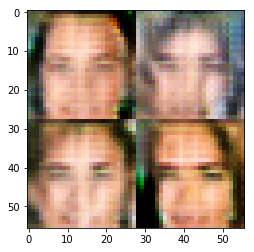

Kierros 952, generator 0.6717552542686462 discriminator 1.218815803527832
Kierros 954, generator 0.9387550354003906 discriminator 1.1672828197479248
Kierros 956, generator 0.7943155765533447 discriminator 1.3787339925765991
Kierros 958, generator 0.8032438158988953 discriminator 1.3264042139053345
Kierros 960, generator 0.639582097530365 discriminator 1.4495415687561035
Kierros 962, generator 0.7920305728912354 discriminator 1.2998852729797363
Kierros 964, generator 0.630843997001648 discriminator 1.3033397197723389
Kierros 966, generator 0.7596600651741028 discriminator 1.332074761390686
Kierros 968, generator 0.8777363300323486 discriminator 1.2008237838745117
Kierros 970, generator 0.6780248880386353 discriminator 1.2158677577972412
Kierros 972, generator 0.8075810670852661 discriminator 1.3775584697723389
Kierros 974, generator 0.6472886800765991 discriminator 1.2374013662338257
Kierros 976, generator 0.6138709783554077 discriminator 1.1926082372665405
Kierros 978, generator 0.8075

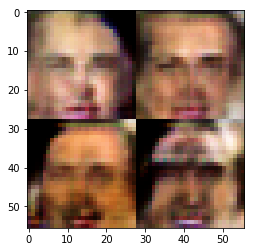

Kierros 1002, generator 0.8532795310020447 discriminator 1.347503900527954
Kierros 1004, generator 0.7240346074104309 discriminator 1.4318394660949707
Kierros 1006, generator 0.6399560570716858 discriminator 1.4600896835327148
Kierros 1008, generator 0.7128034830093384 discriminator 1.2762329578399658
Kierros 1010, generator 0.9113143682479858 discriminator 1.2375298738479614
Kierros 1012, generator 0.5971648097038269 discriminator 1.372535228729248
Kierros 1014, generator 0.727765679359436 discriminator 1.3459110260009766
Kierros 1016, generator 0.6794314384460449 discriminator 1.433404564857483
Kierros 1018, generator 0.59014892578125 discriminator 1.5043679475784302
Kierros 1020, generator 0.7823018431663513 discriminator 1.2163888216018677
Kierros 1022, generator 0.8539457321166992 discriminator 1.2072129249572754
Kierros 1024, generator 0.590114176273346 discriminator 1.391683578491211
Kierros 1026, generator 0.7176498174667358 discriminator 1.3294912576675415
Kierros 1028, genera

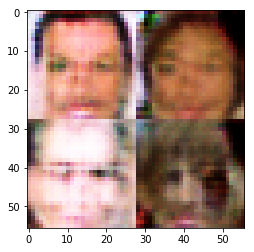

Kierros 1052, generator 0.5197624564170837 discriminator 1.384392261505127
Kierros 1054, generator 0.7682710886001587 discriminator 1.2486357688903809
Kierros 1056, generator 0.7327885627746582 discriminator 1.4977521896362305
Kierros 1058, generator 0.7249196767807007 discriminator 1.2643589973449707
Kierros 1060, generator 0.7290342450141907 discriminator 1.3199647665023804
Kierros 1062, generator 0.9592172503471375 discriminator 1.1981453895568848
Kierros 1064, generator 0.7030112743377686 discriminator 1.2245852947235107
Kierros 1066, generator 0.7612273693084717 discriminator 1.2104432582855225
Kierros 1068, generator 0.5934816598892212 discriminator 1.3918330669403076
Kierros 1070, generator 0.9380769729614258 discriminator 1.269526481628418
Kierros 1072, generator 0.754314661026001 discriminator 1.416114330291748
Kierros 1074, generator 0.6829406023025513 discriminator 1.3631144762039185
Kierros 1076, generator 0.6867697834968567 discriminator 1.325648546218872
Kierros 1078, gen

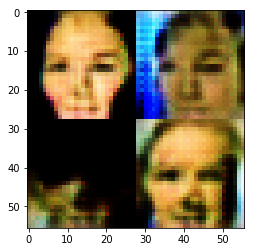

Kierros 1102, generator 0.6493326425552368 discriminator 1.1885676383972168
Kierros 1114, generator 0.5456782579421997 discriminator 1.5192415714263916
Kierros 1116, generator 1.021772861480713 discriminator 1.2731459140777588
Kierros 1118, generator 0.9089456796646118 discriminator 1.403812050819397
Kierros 1120, generator 0.8251834511756897 discriminator 1.4521598815917969
Kierros 1122, generator 0.9814967513084412 discriminator 1.124784231185913
Kierros 1124, generator 0.7913240194320679 discriminator 1.2954329252243042
Kierros 1126, generator 0.7173668742179871 discriminator 1.302128791809082
Kierros 1128, generator 0.7817780375480652 discriminator 1.299196481704712
Kierros 1130, generator 0.833581268787384 discriminator 1.2103726863861084
Kierros 1132, generator 0.645338237285614 discriminator 1.3058762550354004
Kierros 1134, generator 0.6362199783325195 discriminator 1.3091167211532593
Kierros 1136, generator 0.8285807967185974 discriminator 1.2735652923583984
Kierros 1138, gener

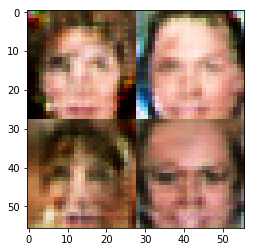

Kierros 1152, generator 0.819542407989502 discriminator 1.2961125373840332
Kierros 1154, generator 0.8328620791435242 discriminator 1.2551074028015137
Kierros 1156, generator 0.7596265077590942 discriminator 1.286733627319336
Kierros 1158, generator 0.6786689162254333 discriminator 1.29058837890625
Kierros 1160, generator 0.8201545476913452 discriminator 1.3076171875
Kierros 1162, generator 0.5598709583282471 discriminator 1.333615779876709
Kierros 1164, generator 0.9375168681144714 discriminator 1.167264461517334
Kierros 1166, generator 0.8311986923217773 discriminator 1.2757903337478638
Kierros 1168, generator 0.9772300124168396 discriminator 1.4194555282592773
Kierros 1170, generator 0.4748149812221527 discriminator 1.51547372341156
Kierros 1172, generator 0.8835874795913696 discriminator 1.496093511581421
Kierros 1174, generator 0.7454200983047485 discriminator 1.2619962692260742
Kierros 1176, generator 0.7250731587409973 discriminator 1.1672828197479248
Kierros 1178, generator 0.5

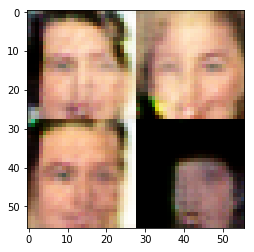

Kierros 1202, generator 0.7229957580566406 discriminator 1.2878037691116333
Kierros 1204, generator 0.6397256851196289 discriminator 1.2938141822814941
Kierros 1206, generator 0.7203180193901062 discriminator 1.4882123470306396
Kierros 1208, generator 0.7014261484146118 discriminator 1.2675660848617554
Kierros 1210, generator 0.6880081295967102 discriminator 1.2319984436035156
Kierros 1212, generator 0.6032611727714539 discriminator 1.4658634662628174
Kierros 1214, generator 0.6897661089897156 discriminator 1.3727397918701172
Kierros 1216, generator 0.7269836068153381 discriminator 1.40348219871521
Kierros 1218, generator 0.44955554604530334 discriminator 1.466566801071167
Kierros 1220, generator 0.6523784399032593 discriminator 1.3527045249938965
Kierros 1222, generator 0.817030668258667 discriminator 1.4089078903198242
Kierros 1224, generator 0.7129963636398315 discriminator 1.2629668712615967
Kierros 1226, generator 0.608670711517334 discriminator 1.3560492992401123
Kierros 1228, ge

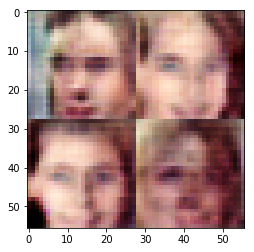

Kierros 1252, generator 0.7107941508293152 discriminator 1.2861965894699097
Kierros 1254, generator 0.7089307904243469 discriminator 1.3568453788757324
Kierros 1256, generator 0.526032030582428 discriminator 1.4478211402893066
Kierros 1258, generator 0.7633443474769592 discriminator 1.245573878288269
Kierros 1260, generator 0.6085951924324036 discriminator 1.3823457956314087
Kierros 1262, generator 0.5996231436729431 discriminator 1.4006623029708862
Kierros 1264, generator 0.8845850825309753 discriminator 1.295251727104187
Kierros 1266, generator 0.6102457046508789 discriminator 1.345767855644226
Kierros 1268, generator 0.7200334668159485 discriminator 1.318486213684082
Kierros 1270, generator 0.8772651553153992 discriminator 1.3214764595031738
Kierros 1272, generator 0.6933568716049194 discriminator 1.3209391832351685
Kierros 1274, generator 0.5938674807548523 discriminator 1.348548173904419
Kierros 1276, generator 0.7865633964538574 discriminator 1.1581943035125732
Kierros 1278, gene

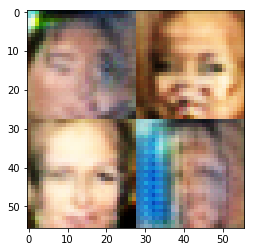

Kierros 1302, generator 0.8284749388694763 discriminator 1.248327612876892
Kierros 1304, generator 0.9255592823028564 discriminator 1.3226041793823242
Kierros 1306, generator 0.589117169380188 discriminator 1.3534395694732666
Kierros 1308, generator 1.0781447887420654 discriminator 1.3690834045410156
Kierros 1310, generator 0.8634397387504578 discriminator 1.261155366897583
Kierros 1312, generator 0.724242627620697 discriminator 1.3889155387878418
Kierros 1314, generator 0.7340585589408875 discriminator 1.2826061248779297
Kierros 1316, generator 0.688689649105072 discriminator 1.263340950012207
Kierros 1318, generator 0.7191681265830994 discriminator 1.1942873001098633
Kierros 1320, generator 0.7902339100837708 discriminator 1.348473310470581
Kierros 1322, generator 0.5412832498550415 discriminator 1.4287104606628418
Kierros 1324, generator 0.5642083287239075 discriminator 1.4237282276153564
Kierros 1326, generator 0.8714168071746826 discriminator 1.1553549766540527
Kierros 1328, gener

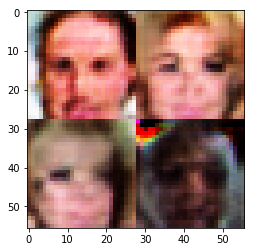

Kierros 1352, generator 0.7017069458961487 discriminator 1.2868010997772217
Kierros 1354, generator 0.6897595524787903 discriminator 1.3498649597167969
Kierros 1356, generator 0.7613139748573303 discriminator 1.297575831413269
Kierros 1358, generator 0.8269134163856506 discriminator 1.273946762084961
Kierros 1360, generator 0.9189992547035217 discriminator 1.235321044921875
Kierros 1362, generator 0.5832111835479736 discriminator 1.3616137504577637
Kierros 1364, generator 0.5748757719993591 discriminator 1.2654179334640503
Kierros 1366, generator 0.822063148021698 discriminator 1.2946183681488037
Kierros 1368, generator 0.6125515699386597 discriminator 1.3671857118606567
Kierros 1370, generator 0.956540584564209 discriminator 1.2928032875061035
Kierros 1372, generator 0.6874033212661743 discriminator 1.4401891231536865
Kierros 1374, generator 0.8334497213363647 discriminator 1.26675283908844
Kierros 1376, generator 0.6739240884780884 discriminator 1.2417243719100952
Kierros 1378, gener

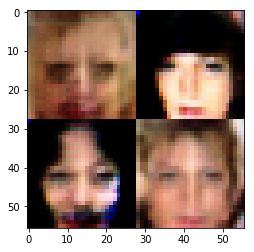

Kierros 1402, generator 0.6542792916297913 discriminator 1.2841883897781372
Kierros 1404, generator 0.6961050033569336 discriminator 1.3282777070999146
Kierros 1406, generator 0.7448982000350952 discriminator 1.3545427322387695
Kierros 1408, generator 0.6408513784408569 discriminator 1.3157782554626465
Kierros 1410, generator 0.5925623178482056 discriminator 1.289381980895996
Kierros 1412, generator 0.7742819786071777 discriminator 1.2321480512619019
Kierros 1414, generator 0.7550109028816223 discriminator 1.262362003326416
Kierros 1416, generator 0.7334551215171814 discriminator 1.2262896299362183
Kierros 1418, generator 0.7972607612609863 discriminator 1.3309677839279175
Kierros 1420, generator 0.6663997173309326 discriminator 1.3168387413024902
Kierros 1422, generator 0.6681103110313416 discriminator 1.3215217590332031
Kierros 1424, generator 0.8311474919319153 discriminator 1.3765556812286377
Kierros 1426, generator 0.7640382647514343 discriminator 1.246129035949707
Kierros 1428, g

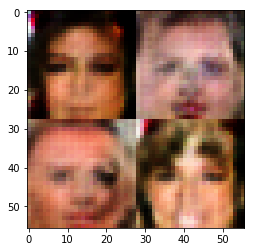

Kierros 1452, generator 0.8894182443618774 discriminator 1.2339529991149902
Kierros 1454, generator 0.7592198848724365 discriminator 1.3094711303710938
Kierros 1456, generator 0.6446709036827087 discriminator 1.217839002609253
Kierros 1458, generator 0.729266881942749 discriminator 1.2011394500732422
Kierros 1460, generator 0.5533795356750488 discriminator 1.342976689338684
Kierros 1462, generator 0.6662076711654663 discriminator 1.4244431257247925
Kierros 1464, generator 0.8384482860565186 discriminator 1.423144817352295
Kierros 1466, generator 0.8276622295379639 discriminator 1.3080703020095825
Kierros 1468, generator 0.8838216662406921 discriminator 1.240570306777954
Kierros 1470, generator 0.5788272023200989 discriminator 1.2764954566955566
Kierros 1472, generator 0.6360180974006653 discriminator 1.2942280769348145
Kierros 1474, generator 0.7044304609298706 discriminator 1.2241991758346558
Kierros 1476, generator 0.9416590929031372 discriminator 1.3510735034942627
Kierros 1478, gen

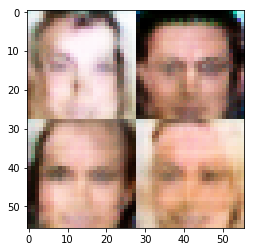

Kierros 1502, generator 0.7827546000480652 discriminator 1.2354154586791992
Kierros 1504, generator 0.859474778175354 discriminator 1.3478302955627441
Kierros 1506, generator 0.8075032830238342 discriminator 1.2325356006622314
Kierros 1508, generator 0.6646356582641602 discriminator 1.3473165035247803
Kierros 1510, generator 0.6334391832351685 discriminator 1.1591501235961914
Kierros 1512, generator 0.7290444374084473 discriminator 1.4187235832214355
Kierros 1514, generator 0.563361406326294 discriminator 1.5033938884735107
Kierros 1516, generator 0.6765642762184143 discriminator 1.620260238647461
Kierros 1518, generator 0.8302986025810242 discriminator 1.5667076110839844
Kierros 1520, generator 0.656897783279419 discriminator 1.3128100633621216
Kierros 1522, generator 0.6518759727478027 discriminator 1.3269782066345215
Kierros 1524, generator 0.7205339670181274 discriminator 1.3492884635925293
Kierros 1526, generator 0.8148157596588135 discriminator 1.263806700706482
Kierros 1528, gen

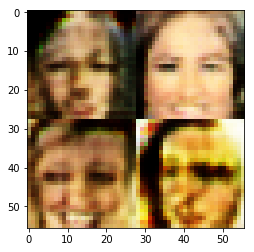

Kierros 1552, generator 0.6512619256973267 discriminator 1.2754579782485962
Kierros 1554, generator 0.6581640243530273 discriminator 1.318158745765686
Kierros 1556, generator 0.8190507888793945 discriminator 1.270856261253357
Kierros 1558, generator 0.49133387207984924 discriminator 1.6330235004425049
Kierros 1560, generator 0.5640499591827393 discriminator 1.2952369451522827
Kierros 1562, generator 0.8963361382484436 discriminator 1.056288719177246
Kierros 1564, generator 0.8158764243125916 discriminator 1.2399890422821045
Kierros 1566, generator 0.6170246601104736 discriminator 1.371445655822754
Kierros 1568, generator 0.783586323261261 discriminator 1.3422060012817383
Kierros 1570, generator 0.6968958377838135 discriminator 1.4027304649353027
Kierros 1572, generator 0.7984029650688171 discriminator 1.2250274419784546
Kierros 1574, generator 0.6439122557640076 discriminator 1.1954916715621948
Kierros 1576, generator 0.6782100200653076 discriminator 1.4040672779083252
Kierros 1578, ge

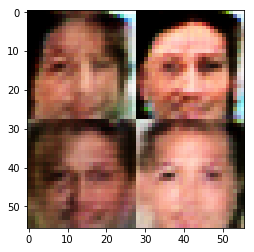

Kierros 1602, generator 0.6391863822937012 discriminator 1.2806485891342163
Kierros 1604, generator 0.6962028741836548 discriminator 1.2704718112945557
Kierros 1606, generator 0.8176411986351013 discriminator 1.431138277053833
Kierros 1608, generator 0.8262410759925842 discriminator 1.4351078271865845
Kierros 1610, generator 0.7797983288764954 discriminator 1.3243982791900635
Kierros 1612, generator 0.7945497632026672 discriminator 1.3045319318771362
Kierros 1614, generator 0.6487905383110046 discriminator 1.305662989616394
Kierros 1616, generator 0.7167261838912964 discriminator 1.3602945804595947
Kierros 1618, generator 0.8137105703353882 discriminator 1.1813313961029053
Kierros 1620, generator 0.6714861989021301 discriminator 1.188687801361084
Kierros 1622, generator 0.710533082485199 discriminator 1.253748893737793
Kierros 1624, generator 0.5048415064811707 discriminator 1.4365811347961426
Kierros 1626, generator 0.5364362597465515 discriminator 1.4909111261367798
Kierros 1628, gen

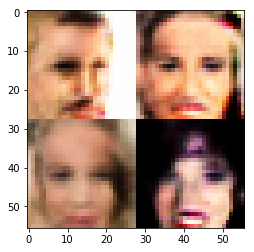

Kierros 1652, generator 0.7678773999214172 discriminator 1.3040233850479126
Kierros 1654, generator 0.7408447861671448 discriminator 1.29533052444458
Kierros 1656, generator 0.7463312745094299 discriminator 1.3423938751220703
Kierros 1658, generator 0.7619370222091675 discriminator 1.2699005603790283
Kierros 1660, generator 0.7073372602462769 discriminator 1.2964894771575928
Kierros 1662, generator 0.6853814125061035 discriminator 1.4663701057434082
Kierros 1664, generator 0.6281419992446899 discriminator 1.2691344022750854
Kierros 1666, generator 0.5949508547782898 discriminator 1.3975114822387695
Kierros 1668, generator 0.7771745920181274 discriminator 1.3117694854736328
Kierros 1670, generator 0.737858235836029 discriminator 1.2613143920898438
Kierros 1672, generator 0.7415539622306824 discriminator 1.447372317314148
Kierros 1674, generator 0.5978789925575256 discriminator 1.3617665767669678
Kierros 1676, generator 0.7464966773986816 discriminator 1.4960434436798096
Kierros 1678, ge

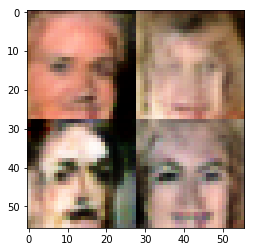

Kierros 1702, generator 0.4835700988769531 discriminator 1.4400560855865479
Kierros 1704, generator 0.8986312747001648 discriminator 1.3902736902236938
Kierros 1706, generator 0.7521347999572754 discriminator 1.2862855195999146
Kierros 1708, generator 0.8771588802337646 discriminator 1.247098684310913
Kierros 1710, generator 0.6314873695373535 discriminator 1.3325691223144531
Kierros 1712, generator 0.6314387917518616 discriminator 1.316720724105835
Kierros 1714, generator 0.7264356017112732 discriminator 1.3268324136734009
Kierros 1716, generator 0.739137589931488 discriminator 1.317221760749817
Kierros 1718, generator 0.7840046286582947 discriminator 1.2185676097869873
Kierros 1720, generator 0.7773264646530151 discriminator 1.2529966831207275
Kierros 1722, generator 0.7581661939620972 discriminator 1.1770961284637451
Kierros 1724, generator 0.8540216684341431 discriminator 1.2835056781768799
Kierros 1726, generator 0.4975234568119049 discriminator 1.4385910034179688
Kierros 1728, ge

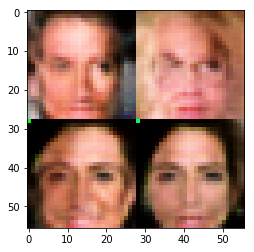

Kierros 1752, generator 0.47783154249191284 discriminator 1.4856442213058472
Kierros 1754, generator 0.6781911849975586 discriminator 1.275344729423523
Kierros 1756, generator 0.722326397895813 discriminator 1.3338013887405396
Kierros 1758, generator 0.9911407232284546 discriminator 1.3056648969650269
Kierros 1760, generator 0.6902936100959778 discriminator 1.3601213693618774
Kierros 1762, generator 0.8413121700286865 discriminator 1.3567869663238525
Kierros 1764, generator 0.8135401010513306 discriminator 1.3038604259490967
Kierros 1766, generator 0.8444082140922546 discriminator 1.2305315732955933
Kierros 1768, generator 0.6720316410064697 discriminator 1.1633158922195435
Kierros 1770, generator 0.8403966426849365 discriminator 1.2443504333496094
Kierros 1772, generator 0.6334160566329956 discriminator 1.3766131401062012
Kierros 1774, generator 0.5523083806037903 discriminator 1.4393970966339111
Kierros 1776, generator 0.7627936601638794 discriminator 1.3426003456115723
Kierros 1778,

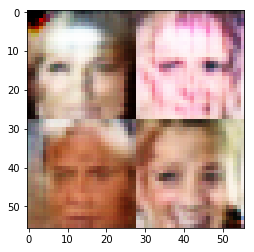

Kierros 1802, generator 0.84771728515625 discriminator 1.1635304689407349
Kierros 1804, generator 0.661838710308075 discriminator 1.3121812343597412
Kierros 1806, generator 0.4467410147190094 discriminator 1.6036536693572998
Kierros 1808, generator 0.6230072379112244 discriminator 1.3520511388778687
Kierros 1810, generator 0.7514266967773438 discriminator 1.3710800409317017
Kierros 1812, generator 0.681952953338623 discriminator 1.3407647609710693
Kierros 1814, generator 0.9715721011161804 discriminator 1.241602897644043
Kierros 1816, generator 0.6113729476928711 discriminator 1.423541784286499
Kierros 1818, generator 0.5543454885482788 discriminator 1.494138240814209
Kierros 1820, generator 0.938362717628479 discriminator 1.3033019304275513
Kierros 1822, generator 0.599541187286377 discriminator 1.4376294612884521
Kierros 1824, generator 0.6696439385414124 discriminator 1.2424477338790894
Kierros 1826, generator 0.7317708730697632 discriminator 1.265073299407959
Kierros 1828, generato

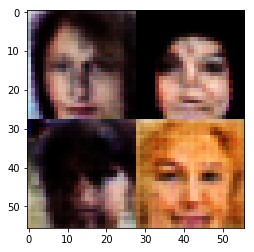

Kierros 1852, generator 0.7417809367179871 discriminator 1.2631226778030396
Kierros 1854, generator 0.8394457101821899 discriminator 1.2970123291015625
Kierros 1856, generator 0.7972498536109924 discriminator 1.2980883121490479
Kierros 1858, generator 0.6133072972297668 discriminator 1.4935026168823242
Kierros 1860, generator 0.7916722297668457 discriminator 1.3164384365081787
Kierros 1862, generator 0.6156468391418457 discriminator 1.2615960836410522
Kierros 1864, generator 0.6277638077735901 discriminator 1.3571138381958008
Kierros 1866, generator 1.0351864099502563 discriminator 1.2547452449798584
Kierros 1868, generator 0.7293238639831543 discriminator 1.2393133640289307
Kierros 1870, generator 0.6984095573425293 discriminator 1.311356544494629
Kierros 1872, generator 0.5357494950294495 discriminator 1.357413649559021
Kierros 1874, generator 0.7605727910995483 discriminator 1.5291814804077148
Kierros 1876, generator 0.5775172114372253 discriminator 1.4646484851837158
Kierros 1878, 

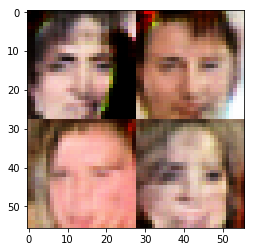

Kierros 1902, generator 0.7495131492614746 discriminator 1.3787784576416016
Kierros 1904, generator 0.943232536315918 discriminator 1.3026328086853027
Kierros 1906, generator 0.7822822332382202 discriminator 1.324343204498291
Kierros 1908, generator 0.6279424428939819 discriminator 1.2989554405212402
Kierros 1910, generator 0.6148092746734619 discriminator 1.305809736251831
Kierros 1912, generator 0.786358654499054 discriminator 1.3248939514160156
Kierros 1914, generator 0.9186311960220337 discriminator 1.1622986793518066
Kierros 1916, generator 0.765764057636261 discriminator 1.3739428520202637
Kierros 1918, generator 0.46243029832839966 discriminator 1.4382520914077759
Kierros 1920, generator 0.7711797952651978 discriminator 1.369527816772461
Kierros 1922, generator 0.698576807975769 discriminator 1.386756420135498
Kierros 1924, generator 0.6403141617774963 discriminator 1.426345705986023
Kierros 1926, generator 0.7370338439941406 discriminator 1.314030647277832
Kierros 1928, generat

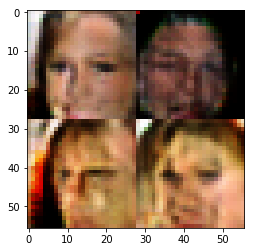

Kierros 1952, generator 0.6083155274391174 discriminator 1.2941186428070068
Kierros 1954, generator 0.7756012082099915 discriminator 1.359640121459961
Kierros 1956, generator 0.7992573380470276 discriminator 1.2633717060089111
Kierros 1958, generator 0.7161828875541687 discriminator 1.3354735374450684
Kierros 1960, generator 0.5477991700172424 discriminator 1.4187469482421875
Kierros 1962, generator 0.8094233274459839 discriminator 1.3839161396026611
Kierros 1964, generator 0.6406612396240234 discriminator 1.3883085250854492
Kierros 1966, generator 0.689958930015564 discriminator 1.2951927185058594
Kierros 1968, generator 0.7884561419487 discriminator 1.3979474306106567
Kierros 1970, generator 0.7497705221176147 discriminator 1.3811068534851074
Kierros 1972, generator 0.5454347729682922 discriminator 1.396945595741272
Kierros 1974, generator 0.6814542412757874 discriminator 1.2836350202560425
Kierros 1976, generator 0.8073780536651611 discriminator 1.22420072555542
Kierros 1978, genera

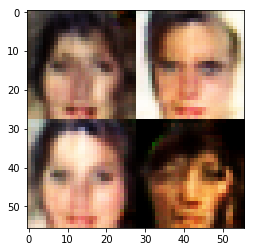

Kierros 2002, generator 0.7240166068077087 discriminator 1.3559832572937012
Kierros 2004, generator 0.782853901386261 discriminator 1.4156404733657837
Kierros 2006, generator 0.7687095999717712 discriminator 1.2616970539093018
Kierros 2008, generator 0.6932287216186523 discriminator 1.3056402206420898
Kierros 2010, generator 0.7277085185050964 discriminator 1.4087436199188232
Kierros 2012, generator 0.6971567869186401 discriminator 1.3000149726867676
Kierros 2014, generator 0.7628340721130371 discriminator 1.3175432682037354
Kierros 2016, generator 0.6221723556518555 discriminator 1.380892276763916
Kierros 2018, generator 0.7390215396881104 discriminator 1.3567020893096924
Kierros 2020, generator 0.724921703338623 discriminator 1.275299072265625
Kierros 2022, generator 0.7329061031341553 discriminator 1.3730511665344238
Kierros 2024, generator 0.6573916077613831 discriminator 1.4162991046905518
Kierros 2026, generator 0.7371363043785095 discriminator 1.4538249969482422
Kierros 2028, ge

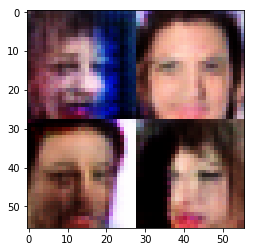

Kierros 2052, generator 0.7431691288948059 discriminator 1.3610074520111084
Kierros 2054, generator 0.5884118676185608 discriminator 1.434127688407898
Kierros 2056, generator 0.6547223329544067 discriminator 1.2669761180877686
Kierros 2058, generator 0.7423933148384094 discriminator 1.380210518836975
Kierros 2060, generator 0.6399506330490112 discriminator 1.3798502683639526
Kierros 2062, generator 0.7726307511329651 discriminator 1.3783833980560303
Kierros 2064, generator 0.6593894958496094 discriminator 1.2379534244537354
Kierros 2066, generator 0.8160308599472046 discriminator 1.2416996955871582
Kierros 2068, generator 0.689725935459137 discriminator 1.3221428394317627
Kierros 2070, generator 0.6514536142349243 discriminator 1.3507356643676758
Kierros 2072, generator 0.7078865170478821 discriminator 1.3285815715789795
Kierros 2074, generator 0.717093825340271 discriminator 1.3203349113464355
Kierros 2076, generator 0.7802057862281799 discriminator 1.2521812915802002
Kierros 2078, ge

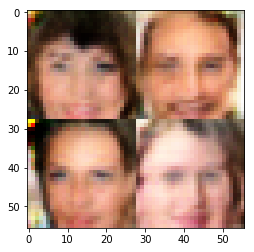

Kierros 2102, generator 0.7768079042434692 discriminator 1.4157490730285645
Kierros 2104, generator 0.7735475301742554 discriminator 1.2709596157073975
Kierros 2106, generator 0.7385093569755554 discriminator 1.250652551651001
Kierros 2108, generator 0.6643116474151611 discriminator 1.2569642066955566
Kierros 2110, generator 0.7629282474517822 discriminator 1.1941897869110107
Kierros 2112, generator 0.6702074408531189 discriminator 1.3320982456207275
Kierros 2114, generator 0.5763460397720337 discriminator 1.391164779663086
Kierros 2116, generator 0.8265897631645203 discriminator 1.4078389406204224
Kierros 2118, generator 0.7294288277626038 discriminator 1.446281909942627
Kierros 2120, generator 0.7743408679962158 discriminator 1.3510576486587524
Kierros 2122, generator 0.6374139189720154 discriminator 1.4112569093704224
Kierros 2124, generator 0.6648236513137817 discriminator 1.3323631286621094
Kierros 2126, generator 0.7685388326644897 discriminator 1.2000386714935303
Kierros 2128, g

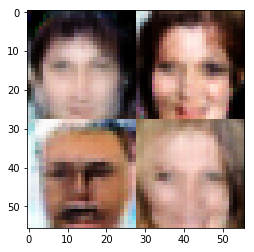

Kierros 2152, generator 0.8423643112182617 discriminator 1.3343899250030518
Kierros 2154, generator 0.7291437387466431 discriminator 1.3978803157806396
Kierros 2156, generator 0.7218068242073059 discriminator 1.4120869636535645
Kierros 2158, generator 0.6753727793693542 discriminator 1.2701642513275146
Kierros 2160, generator 0.6484273672103882 discriminator 1.327453374862671
Kierros 2162, generator 0.7668299674987793 discriminator 1.3734185695648193
Kierros 2164, generator 0.6993599534034729 discriminator 1.4299986362457275
Kierros 2166, generator 0.6637537479400635 discriminator 1.3551461696624756
Kierros 2168, generator 0.804499626159668 discriminator 1.4302736520767212
Kierros 2170, generator 0.6508370041847229 discriminator 1.3426313400268555
Kierros 2172, generator 0.8451308608055115 discriminator 1.3182872533798218
Kierros 2174, generator 0.6193082928657532 discriminator 1.323439598083496
Kierros 2176, generator 0.8369826674461365 discriminator 1.2697632312774658
Kierros 2178, g

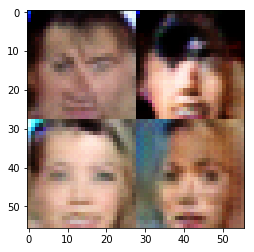

Kierros 2202, generator 0.7082136273384094 discriminator 1.3155181407928467
Kierros 2204, generator 0.676405131816864 discriminator 1.5704433917999268
Kierros 2206, generator 0.6621233224868774 discriminator 1.4646739959716797
Kierros 2208, generator 0.8233741521835327 discriminator 1.580129623413086
Kierros 2210, generator 0.6421209573745728 discriminator 1.38559889793396
Kierros 2212, generator 0.5791463255882263 discriminator 1.2842638492584229
Kierros 2214, generator 0.852135419845581 discriminator 1.0725774765014648
Kierros 2216, generator 0.7066875100135803 discriminator 1.2142857313156128
Kierros 2218, generator 0.8547389507293701 discriminator 1.3234121799468994
Kierros 2220, generator 0.6857007741928101 discriminator 1.4208579063415527
Kierros 2222, generator 0.7267559766769409 discriminator 1.4992529153823853
Kierros 2224, generator 0.48613855242729187 discriminator 1.401096224784851
Kierros 2226, generator 0.8315137624740601 discriminator 1.2441365718841553
Kierros 2228, gen

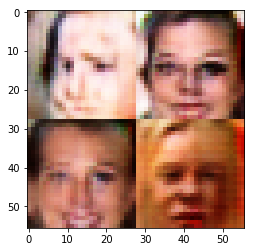

Kierros 2252, generator 0.7660375237464905 discriminator 1.381321907043457
Kierros 2254, generator 0.506939709186554 discriminator 1.4394341707229614
Kierros 2256, generator 0.8274375796318054 discriminator 1.2864820957183838
Kierros 2258, generator 0.6157299876213074 discriminator 1.2658970355987549
Kierros 2260, generator 0.7835434675216675 discriminator 1.284470796585083
Kierros 2262, generator 0.6750079393386841 discriminator 1.529750108718872
Kierros 2264, generator 0.6655409932136536 discriminator 1.5384294986724854
Kierros 2266, generator 0.647134006023407 discriminator 1.4616000652313232
Kierros 2268, generator 0.6957604289054871 discriminator 1.2120459079742432
Kierros 2270, generator 0.6666839122772217 discriminator 1.3454712629318237
Kierros 2272, generator 0.9947888851165771 discriminator 1.281661033630371
Kierros 2274, generator 0.7083297371864319 discriminator 1.4046196937561035
Kierros 2276, generator 0.6548925638198853 discriminator 1.3869001865386963
Kierros 2278, gene

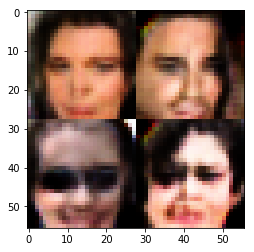

Kierros 2302, generator 0.6315464377403259 discriminator 1.3702291250228882
Kierros 2304, generator 0.8242340683937073 discriminator 1.2521071434020996
Kierros 2306, generator 0.4564017951488495 discriminator 1.486039161682129
Kierros 2308, generator 0.7602422833442688 discriminator 1.427909255027771
Kierros 2310, generator 0.6122589111328125 discriminator 1.4784648418426514
Kierros 2312, generator 0.6255946159362793 discriminator 1.405388355255127
Kierros 2314, generator 0.6902801990509033 discriminator 1.3723422288894653
Kierros 2316, generator 0.8579154014587402 discriminator 1.2990949153900146
Kierros 2318, generator 0.6151722073554993 discriminator 1.2938642501831055
Kierros 2320, generator 0.7372635006904602 discriminator 1.3457467555999756
Kierros 2322, generator 0.7239547371864319 discriminator 1.393525242805481
Kierros 2324, generator 0.6772502064704895 discriminator 1.3228751420974731
Kierros 2326, generator 0.679628849029541 discriminator 1.3550206422805786
Kierros 2328, gen

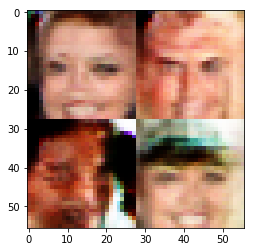

Kierros 2352, generator 0.6821553111076355 discriminator 1.3554844856262207
Kierros 2354, generator 0.7573949098587036 discriminator 1.2533282041549683
Kierros 2356, generator 0.7419363260269165 discriminator 1.3107376098632812
Kierros 2358, generator 0.7151174545288086 discriminator 1.3058388233184814
Kierros 2360, generator 0.6188626289367676 discriminator 1.3641518354415894
Kierros 2362, generator 0.7839232683181763 discriminator 1.3634002208709717
Kierros 2364, generator 0.6764734983444214 discriminator 1.3698277473449707
Kierros 2366, generator 0.8415725827217102 discriminator 1.2601792812347412
Kierros 2368, generator 0.7604713439941406 discriminator 1.2593425512313843
Kierros 2370, generator 0.6091068387031555 discriminator 1.3566555976867676
Kierros 2372, generator 0.667835533618927 discriminator 1.4706368446350098
Kierros 2374, generator 0.8959845900535583 discriminator 1.289618968963623
Kierros 2376, generator 0.7038640975952148 discriminator 1.224320411682129
Kierros 2378, g

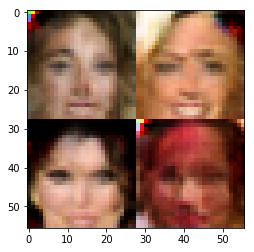

Kierros 2402, generator 0.7831647992134094 discriminator 1.333918809890747
Kierros 2404, generator 0.566474974155426 discriminator 1.4228880405426025
Kierros 2406, generator 0.6720061302185059 discriminator 1.3216001987457275
Kierros 2408, generator 0.8183762431144714 discriminator 1.2821035385131836
Kierros 2410, generator 0.6820386052131653 discriminator 1.260796070098877
Kierros 2412, generator 0.6417590379714966 discriminator 1.2847120761871338
Kierros 2414, generator 0.6717398762702942 discriminator 1.4916119575500488
Kierros 2416, generator 0.6397984623908997 discriminator 1.4512029886245728
Kierros 2418, generator 0.9855512380599976 discriminator 1.3246724605560303
Kierros 2420, generator 0.7165027260780334 discriminator 1.3275632858276367
Kierros 2422, generator 0.6982851624488831 discriminator 1.3109869956970215
Kierros 2424, generator 0.7340140342712402 discriminator 1.2393507957458496
Kierros 2426, generator 0.6163715124130249 discriminator 1.4056892395019531
Kierros 2428, g

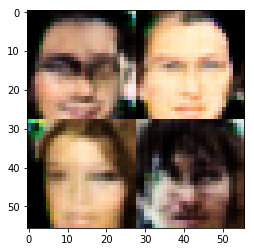

Kierros 2452, generator 0.6948740482330322 discriminator 1.2431135177612305
Kierros 2454, generator 0.7080382704734802 discriminator 1.4011988639831543
Kierros 2456, generator 0.8719258308410645 discriminator 1.3260002136230469
Kierros 2458, generator 0.6012986898422241 discriminator 1.3526767492294312
Kierros 2460, generator 0.7425678968429565 discriminator 1.3427214622497559
Kierros 2462, generator 0.9003148674964905 discriminator 1.2705166339874268
Kierros 2464, generator 0.6661593317985535 discriminator 1.3125360012054443
Kierros 2466, generator 0.761522650718689 discriminator 1.3457633256912231
Kierros 2468, generator 0.6700792908668518 discriminator 1.3288094997406006
Kierros 2470, generator 0.5908170938491821 discriminator 1.364288091659546
Kierros 2472, generator 0.6648406386375427 discriminator 1.3625826835632324
Kierros 2474, generator 0.7998055219650269 discriminator 1.3291211128234863
Kierros 2476, generator 0.6824333667755127 discriminator 1.4578161239624023
Kierros 2478, 

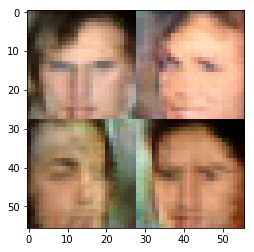

Kierros 2502, generator 0.7639472484588623 discriminator 1.2101867198944092
Kierros 2504, generator 0.7211148738861084 discriminator 1.2176039218902588
Kierros 2506, generator 0.7126859426498413 discriminator 1.346679449081421
Kierros 2508, generator 0.733099639415741 discriminator 1.326087236404419
Kierros 2510, generator 0.49556073546409607 discriminator 1.5019735097885132
Kierros 2512, generator 0.654625654220581 discriminator 1.2295480966567993
Kierros 2514, generator 0.9547950029373169 discriminator 1.1922030448913574
Kierros 2516, generator 0.6370943784713745 discriminator 1.3629579544067383
Kierros 2518, generator 0.7441737651824951 discriminator 1.4028383493423462
Kierros 2520, generator 0.6864590048789978 discriminator 1.4224662780761719
Kierros 2522, generator 0.4511795938014984 discriminator 1.4576427936553955
Kierros 2524, generator 0.7507430911064148 discriminator 1.294419288635254
Kierros 2526, generator 0.661443829536438 discriminator 1.3802820444107056
Kierros 2528, gen

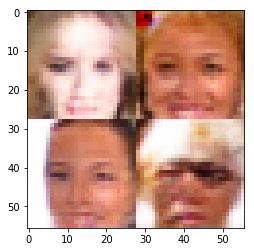

Kierros 2552, generator 0.8054201602935791 discriminator 1.1743156909942627
Kierros 2554, generator 0.7616451978683472 discriminator 1.3278226852416992
Kierros 2556, generator 0.6999834775924683 discriminator 1.333380937576294
Kierros 2558, generator 0.6961979866027832 discriminator 1.470951795578003
Kierros 2560, generator 0.7073367238044739 discriminator 1.405791163444519
Kierros 2562, generator 0.6827375292778015 discriminator 1.324096441268921
Kierros 2564, generator 0.7740997076034546 discriminator 1.2484543323516846
Kierros 2566, generator 0.47501716017723083 discriminator 1.722899317741394
Kierros 2568, generator 0.7711136341094971 discriminator 1.2965362071990967
Kierros 2570, generator 0.7030141353607178 discriminator 1.2204610109329224
Kierros 2572, generator 0.7336201667785645 discriminator 1.2356940507888794
Kierros 2574, generator 0.6953880786895752 discriminator 1.4351556301116943
Kierros 2576, generator 0.7341418266296387 discriminator 1.3431230783462524
Kierros 2578, ge

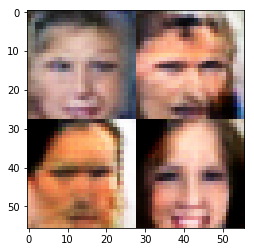

Kierros 2602, generator 0.6662949323654175 discriminator 1.373945951461792
Kierros 2604, generator 0.8316489458084106 discriminator 1.3752943277359009
Kierros 2606, generator 0.6941705942153931 discriminator 1.2897738218307495
Kierros 2608, generator 0.5574749112129211 discriminator 1.4289344549179077
Kierros 2610, generator 0.750602662563324 discriminator 1.361417293548584
Kierros 2612, generator 0.6015632152557373 discriminator 1.3738534450531006
Kierros 2614, generator 0.795866847038269 discriminator 1.3231688737869263
Kierros 2616, generator 0.6659372448921204 discriminator 1.310582160949707
Kierros 2618, generator 0.6469731330871582 discriminator 1.345198154449463
Kierros 2620, generator 0.721352219581604 discriminator 1.400557279586792
Kierros 2622, generator 0.6542162299156189 discriminator 1.3787086009979248
Kierros 2624, generator 0.7478095889091492 discriminator 1.3745777606964111
Kierros 2626, generator 0.6348423957824707 discriminator 1.3630173206329346
Kierros 2628, genera

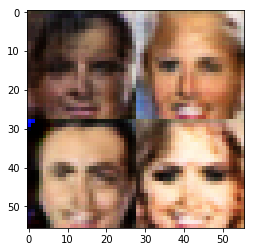

Kierros 2652, generator 0.7171552181243896 discriminator 1.2760006189346313
Kierros 2654, generator 0.6742315292358398 discriminator 1.2771151065826416
Kierros 2656, generator 0.6511538028717041 discriminator 1.3635324239730835
Kierros 2658, generator 0.750553548336029 discriminator 1.2827248573303223
Kierros 2660, generator 0.7025415301322937 discriminator 1.2497044801712036
Kierros 2662, generator 0.8455096483230591 discriminator 1.3146700859069824
Kierros 2664, generator 0.6791796684265137 discriminator 1.3391172885894775
Kierros 2666, generator 0.6747162342071533 discriminator 1.2545902729034424
Kierros 2668, generator 0.4880630671977997 discriminator 1.4180108308792114
Kierros 2670, generator 0.8279206156730652 discriminator 1.2827332019805908
Kierros 2672, generator 0.7405892014503479 discriminator 1.16953444480896
Kierros 2674, generator 0.5441082715988159 discriminator 1.6035481691360474
Kierros 2676, generator 0.45640093088150024 discriminator 1.58835768699646
Kierros 2678, ge

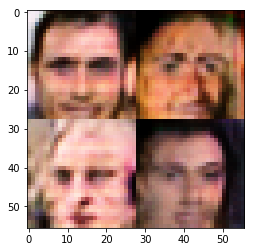

Kierros 2702, generator 0.5045666694641113 discriminator 1.3519295454025269
Kierros 2704, generator 0.693052351474762 discriminator 1.4924938678741455
Kierros 2706, generator 0.5759493112564087 discriminator 1.3977646827697754
Kierros 2708, generator 0.7208826541900635 discriminator 1.3044085502624512
Kierros 2710, generator 0.6431528329849243 discriminator 1.3675509691238403
Kierros 2712, generator 0.6026909351348877 discriminator 1.4347513914108276
Kierros 2714, generator 0.7050740718841553 discriminator 1.5341267585754395
Kierros 2716, generator 0.8465507626533508 discriminator 1.4815194606781006
Kierros 2718, generator 0.7485364079475403 discriminator 1.326614499092102
Kierros 2720, generator 0.8440706133842468 discriminator 1.2844427824020386
Kierros 2722, generator 0.5218909382820129 discriminator 1.3359378576278687
Kierros 2724, generator 0.9019124507904053 discriminator 1.0717467069625854
Kierros 2726, generator 0.6962783932685852 discriminator 1.4876222610473633
Kierros 2728, 

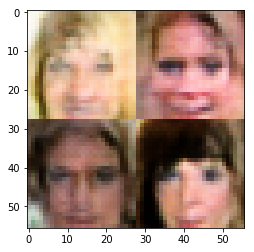

Kierros 2752, generator 0.7877072691917419 discriminator 1.331164836883545
Kierros 2754, generator 0.8751618266105652 discriminator 1.3031210899353027
Kierros 2756, generator 0.7468490600585938 discriminator 1.321507215499878
Kierros 2758, generator 0.3670615255832672 discriminator 1.6336501836776733
Kierros 2760, generator 0.911797285079956 discriminator 1.1315481662750244
Kierros 2762, generator 0.7487159967422485 discriminator 1.2563495635986328
Kierros 2764, generator 0.7023348212242126 discriminator 1.3062412738800049
Kierros 2766, generator 0.8357877135276794 discriminator 1.4157238006591797
Kierros 2768, generator 0.5794431567192078 discriminator 1.3904087543487549
Kierros 2770, generator 0.6875472068786621 discriminator 1.40680992603302
Kierros 2772, generator 0.9209755063056946 discriminator 1.333132266998291
Kierros 2774, generator 0.5909737944602966 discriminator 1.273970365524292
Kierros 2776, generator 0.7159883379936218 discriminator 1.3787682056427002
Kierros 2778, gener

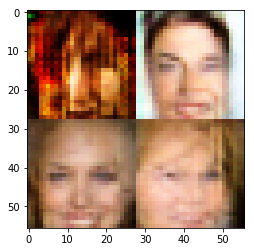

Kierros 2802, generator 0.7607155442237854 discriminator 1.4768280982971191
Kierros 2804, generator 0.5868384838104248 discriminator 1.369642972946167
Kierros 2806, generator 0.7544434070587158 discriminator 1.2306506633758545
Kierros 2808, generator 0.8651700019836426 discriminator 1.1753735542297363
Kierros 2810, generator 0.7258501052856445 discriminator 1.3536916971206665
Kierros 2812, generator 0.6275622844696045 discriminator 1.3647631406784058
Kierros 2814, generator 0.6513223052024841 discriminator 1.5203931331634521
Kierros 2816, generator 0.9103495478630066 discriminator 1.2141053676605225
Kierros 2818, generator 0.5944064259529114 discriminator 1.3595232963562012
Kierros 2820, generator 0.5750172138214111 discriminator 1.3490912914276123
Kierros 2822, generator 0.7197736501693726 discriminator 1.274817943572998
Kierros 2824, generator 0.6916409134864807 discriminator 1.340561866760254
Kierros 2826, generator 0.6916483640670776 discriminator 1.5321030616760254
Kierros 2828, g

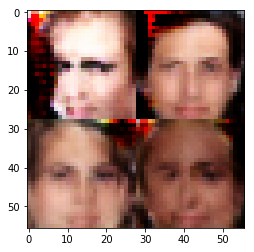

Kierros 2852, generator 0.677472710609436 discriminator 1.367124319076538
Kierros 2854, generator 0.7384086847305298 discriminator 1.480942964553833
Kierros 2856, generator 0.572327733039856 discriminator 1.3767768144607544
Kierros 2858, generator 0.5537614822387695 discriminator 1.4310507774353027
Kierros 2860, generator 0.48761308193206787 discriminator 1.4059144258499146
Kierros 2862, generator 0.7511370778083801 discriminator 1.3285398483276367
Kierros 2864, generator 0.6148333549499512 discriminator 1.4132717847824097
Kierros 2866, generator 0.7223236560821533 discriminator 1.4223451614379883
Kierros 2868, generator 0.7305763959884644 discriminator 1.2878949642181396
Kierros 2870, generator 0.9207819104194641 discriminator 1.3899829387664795
Kierros 2872, generator 0.644404947757721 discriminator 1.411407470703125
Kierros 2874, generator 0.6544930338859558 discriminator 1.4003934860229492
Kierros 2876, generator 0.713486909866333 discriminator 1.2621053457260132
Kierros 2878, gene

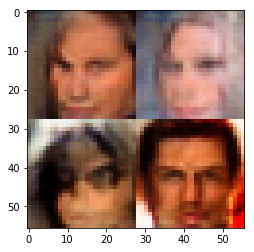

Kierros 2902, generator 0.8063911199569702 discriminator 1.2336262464523315
Kierros 2904, generator 0.7786891460418701 discriminator 1.3472073078155518
Kierros 2906, generator 0.6323117017745972 discriminator 1.355130672454834
Kierros 2908, generator 0.6561866402626038 discriminator 1.352142572402954
Kierros 2910, generator 0.6254551410675049 discriminator 1.3056676387786865
Kierros 2912, generator 0.7129185795783997 discriminator 1.2700594663619995
Kierros 2914, generator 0.7217904925346375 discriminator 1.323671817779541
Kierros 2916, generator 0.7215512990951538 discriminator 1.3251845836639404
Kierros 2918, generator 0.7731555104255676 discriminator 1.3522722721099854
Kierros 2920, generator 0.8409545421600342 discriminator 1.349245548248291
Kierros 2922, generator 0.7985190749168396 discriminator 1.3287585973739624
Kierros 2924, generator 0.8273470401763916 discriminator 1.1726504564285278
Kierros 2926, generator 0.5010144710540771 discriminator 1.567349910736084
Kierros 2928, gen

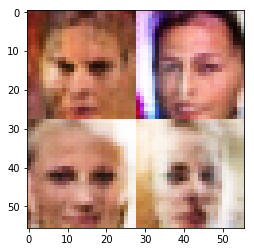

Kierros 2952, generator 0.6884360313415527 discriminator 1.3086720705032349
Kierros 2954, generator 0.7485671639442444 discriminator 1.295252799987793
Kierros 2956, generator 0.6834543943405151 discriminator 1.293327808380127
Kierros 2958, generator 0.715442955493927 discriminator 1.346167802810669
Kierros 2960, generator 0.6346761584281921 discriminator 1.3282504081726074
Kierros 2962, generator 0.7271298170089722 discriminator 1.2852342128753662
Kierros 2964, generator 0.7559514045715332 discriminator 1.3049347400665283
Kierros 2966, generator 0.6175960898399353 discriminator 1.3701165914535522
Kierros 2968, generator 0.8176127672195435 discriminator 1.3833996057510376
Kierros 2970, generator 0.8343396782875061 discriminator 1.308229684829712
Kierros 2972, generator 0.8558370471000671 discriminator 1.3362009525299072
Kierros 2974, generator 0.644289493560791 discriminator 1.3082060813903809
Kierros 2976, generator 0.8316445350646973 discriminator 1.2013795375823975
Kierros 2978, gene

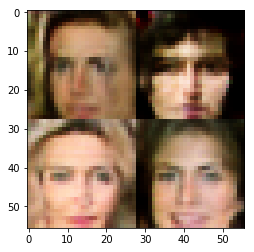

Kierros 3002, generator 0.6664221882820129 discriminator 1.4295358657836914
Kierros 3004, generator 0.8184435963630676 discriminator 1.3273118734359741
Kierros 3006, generator 0.7447646260261536 discriminator 1.3805458545684814
Kierros 3008, generator 0.6939718127250671 discriminator 1.248441219329834
Kierros 3010, generator 0.821193277835846 discriminator 1.253955602645874
Kierros 3012, generator 0.6673426628112793 discriminator 1.4291760921478271
Kierros 3014, generator 0.7119611501693726 discriminator 1.2151762247085571
Kierros 3016, generator 0.6439060568809509 discriminator 1.3737444877624512
Kierros 3018, generator 0.7146286964416504 discriminator 1.4723749160766602
Kierros 3020, generator 0.7251229286193848 discriminator 1.4834048748016357
Kierros 3022, generator 0.6949814558029175 discriminator 1.3977253437042236
Kierros 3024, generator 0.7166064381599426 discriminator 1.3381550312042236
Kierros 3026, generator 0.7306586503982544 discriminator 1.324751853942871
Kierros 3028, ge

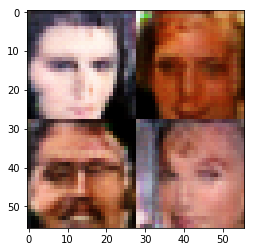

Kierros 3052, generator 0.7468749284744263 discriminator 1.3928124904632568
Kierros 3054, generator 0.8530252575874329 discriminator 1.2958660125732422
Kierros 3056, generator 0.6969782710075378 discriminator 1.337786316871643
Kierros 3058, generator 0.6500873565673828 discriminator 1.4202402830123901
Kierros 3060, generator 0.8125162124633789 discriminator 1.3227612972259521
Kierros 3062, generator 0.6813428401947021 discriminator 1.3012856245040894
Kierros 3064, generator 0.7899966835975647 discriminator 1.3697437047958374
Kierros 3066, generator 0.7961159348487854 discriminator 1.4273111820220947
Kierros 3068, generator 0.6013494729995728 discriminator 1.350423812866211
Kierros 3070, generator 0.7285314202308655 discriminator 1.2796820402145386
Kierros 3072, generator 0.8718735575675964 discriminator 1.287169337272644
Kierros 3074, generator 0.6307188272476196 discriminator 1.3942886590957642
Kierros 3076, generator 0.745551586151123 discriminator 1.415177822113037
Kierros 3078, gen

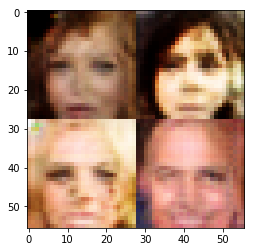

Kierros 3102, generator 0.7821723818778992 discriminator 1.3206791877746582
Kierros 3104, generator 0.5923624038696289 discriminator 1.3591675758361816
Kierros 3106, generator 0.5917182564735413 discriminator 1.3788912296295166
Kierros 3108, generator 0.7816762924194336 discriminator 1.3331403732299805
Kierros 3110, generator 0.6413772106170654 discriminator 1.3823719024658203
Kierros 3112, generator 0.753868043422699 discriminator 1.3951194286346436
Kierros 3114, generator 0.7757717967033386 discriminator 1.3322324752807617
Kierros 3116, generator 0.816103458404541 discriminator 1.3280136585235596
Kierros 3118, generator 0.8165034055709839 discriminator 1.2994544506072998
Kierros 3120, generator 0.6555815935134888 discriminator 1.2917289733886719
Kierros 3122, generator 0.6713060736656189 discriminator 1.2871100902557373
Kierros 3124, generator 0.6970153450965881 discriminator 1.3618314266204834
Kierros 3126, generator 0.6649083495140076 discriminator 1.3155877590179443
Kierros 3128, 

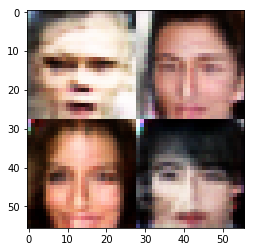

Kierros 3152, generator 0.6494309902191162 discriminator 1.4439475536346436
Kierros 3154, generator 0.6750378012657166 discriminator 1.3652217388153076
Kierros 3156, generator 0.7363601922988892 discriminator 1.3437058925628662
Kierros 3158, generator 0.6475250720977783 discriminator 1.3799126148223877
Kierros 3160, generator 0.6447216868400574 discriminator 1.3609378337860107
Kierros 3162, generator 0.7700775861740112 discriminator 1.3372156620025635
Kierros 3164, generator 0.7350651621818542 discriminator 1.2610814571380615
Epoch 0!


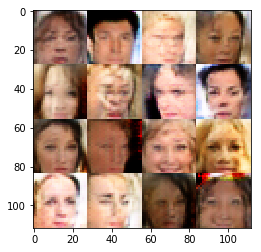

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.